In [1]:
# Import
import os
from PIL import Image

import numpy as np
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset

from sklearn.model_selection import train_test_split
import tensorflow as tf
from src.model.cmaqnet_cond_unet import build_model
from sklearn.metrics import mean_squared_error, r2_score

import geopandas as gpd
from shapely.geometry import Point
import matplotlib as mpl
import matplotlib.pyplot as plt

2025-01-14 14:29:10.708664: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-14 14:29:10.738317: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-14 14:29:10.738347: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-14 14:29:10.738366: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-14 14:29:10.744124: I tensorflow/core/platform/cpu_feature_g

# Training (Nitrate)

In [2]:
emis_ctrl_2019_10 = pd.read_csv('/home/user/workdir/main/resources/ctrl/precursor_control_2019.csv', index_col=0)
emis_ctrl_2019_10['Boundary'] = 1.0

ctrl_data = pd.concat([emis_ctrl_2019_10], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values
emis_data, boundary_data = ctrl_data[:, :85], ctrl_data[:, 85]
# -------------
base_path_2019 = '/home/user/workdir/main/datasets/concentration/2019'

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['Nitrate'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)

In [3]:
from src.model.cmaqnet_cond_unet import build_model

model_path = '/home/user/workdir/main/src/model/nitrate/learning_rate/final_model'  # 모델 저장 경로

epochs = 500  # 훈련 반복 횟수
batch_size = 32  # 배치 크기
test_split = 0.3  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드

X_emis_train, X_emis_test, X_boundary_train, X_boundary_test, y_train, y_test = train_test_split(emis_data, boundary_data, conc_data, test_size=test_split, random_state=random_seed)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Memory growth enabled for GPUs")
    except RuntimeError as e:
        print(e)

# devices=["/GPU:1","/GPU:2","/GPU:3"]
strategy = tf.distribute.MirroredStrategy()
with strategy.scope():
    model = build_model(
        ctrl_dim=17*5,
        cond_dim=[1],
        emb_dims=[64],
        emb_type=['normal'],
        out_channel=1,
        hidden_size=[64, 96],
        hidden_depth=4,
        in_filters=5,
        kernel_size=3,
        activation='silu',
        dropout=0.0,
        use_abs=True
    )
    model.compile(
        optimizer=tf.keras.optimizers.Adam(1e-3),
        loss=tf.keras.losses.MeanSquaredError(),
    )
    
# define callback
def scheduler(epoch, lr):
    if epoch < 1000: return 1e-3
    else: return 1e-4
callback_lr = tf.keras.callbacks.LearningRateScheduler(scheduler)

callback_ckpt = tf.keras.callbacks.ModelCheckpoint(
    filepath='/home/user/workdir/main/src/model/nitrate/learning_rate/final_model-{epoch:02d}-{val_loss:.2f}',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    save_freq='epoch')

history = model.fit(
    x=[X_emis_train, X_boundary_train],   # 입력 데이터 (지역 별 배출량, 경계 조건 값)
    y=y_train,                                          # 입력 데이터의 Label 값 (netCDF에서 PM2.5 값)
    epochs=epochs,
    batch_size=batch_size,
    validation_data=[[X_emis_test, X_boundary_test], y_test], # test 데이터
    callbacks=[callback_lr, callback_ckpt])
model.save(model_path)

def plot_loss(history):
    plt.figure(figsize=(10, 6))
    
    # 학습 손실
    plt.plot(history.history['loss'], label='Training Loss', color='blue')
    # 검증 손실
    plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()
''' '''

Memory growth enabled for GPUs
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


2025-01-13 13:52:36.712552: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 21028 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:19:00.0, compute capability: 8.6
2025-01-13 13:52:36.714117: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 22080 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1a:00.0, compute capability: 8.6
2025-01-13 13:52:36.715665: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 22080 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:67:00.0, compute capability: 8.6
2025-01-13 13:52:36.717151: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 21956 MB memory:  -> device: 3, name: NVIDIA GeForce RTX 3090

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

2025-01-13 13:53:02.996314: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-13 13:53:03.009227: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-13 13:53:03.035698: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-13 13:53:03.127788: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-13 13:53:05.631261: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fecb70383b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-13 13:53:05.631315: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-01-13 13:53:05.631330: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (1): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2025-01-13 13:53:05.63134

3/3 [==============================] - ETA: 0s - loss: 24.7313  INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-01-29.54/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-01-29.54/assets


3/3 [==============================] - 46s 7s/step - loss: 24.7313 - val_loss: 29.5372 - lr: 0.0010
Epoch 2/500
3/3 [==============================] - ETA: 0s - loss: 20.2804INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-02-29.29/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-02-29.29/assets


3/3 [==============================] - 9s 5s/step - loss: 20.2804 - val_loss: 29.2947 - lr: 0.0010
Epoch 3/500
2/3 [===================>..........] - ETA: 0s - loss: 17.1625INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-03-29.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-03-29.03/assets


3/3 [==============================] - 10s 5s/step - loss: 16.8606 - val_loss: 29.0332 - lr: 0.0010
Epoch 4/500
3/3 [==============================] - ETA: 0s - loss: 14.7116INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-04-28.60/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-04-28.60/assets


3/3 [==============================] - 9s 5s/step - loss: 14.7116 - val_loss: 28.5963 - lr: 0.0010
Epoch 5/500
3/3 [==============================] - ETA: 0s - loss: 13.3753INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-05-27.97/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-05-27.97/assets


3/3 [==============================] - 9s 5s/step - loss: 13.3753 - val_loss: 27.9713 - lr: 0.0010
Epoch 6/500
3/3 [==============================] - ETA: 0s - loss: 12.4832INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-06-27.23/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-06-27.23/assets


3/3 [==============================] - 9s 5s/step - loss: 12.4832 - val_loss: 27.2291 - lr: 0.0010
Epoch 7/500
3/3 [==============================] - ETA: 0s - loss: 11.9247INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-07-26.44/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-07-26.44/assets


3/3 [==============================] - 9s 5s/step - loss: 11.9247 - val_loss: 26.4429 - lr: 0.0010
Epoch 8/500
3/3 [==============================] - ETA: 0s - loss: 11.5621INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-08-25.69/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-08-25.69/assets


3/3 [==============================] - 9s 5s/step - loss: 11.5621 - val_loss: 25.6938 - lr: 0.0010
Epoch 9/500
2/3 [===================>..........] - ETA: 0s - loss: 11.3144INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-09-25.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-09-25.03/assets


3/3 [==============================] - 10s 5s/step - loss: 11.2783 - val_loss: 25.0285 - lr: 0.0010
Epoch 10/500
3/3 [==============================] - ETA: 0s - loss: 11.0282INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-10-24.46/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-10-24.46/assets


3/3 [==============================] - 9s 5s/step - loss: 11.0282 - val_loss: 24.4613 - lr: 0.0010
Epoch 11/500
3/3 [==============================] - ETA: 0s - loss: 10.7934INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-11-23.99/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-11-23.99/assets


3/3 [==============================] - 9s 5s/step - loss: 10.7934 - val_loss: 23.9880 - lr: 0.0010
Epoch 12/500
3/3 [==============================] - ETA: 0s - loss: 10.5692INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-12-23.60/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-12-23.60/assets


3/3 [==============================] - 9s 5s/step - loss: 10.5692 - val_loss: 23.6039 - lr: 0.0010
Epoch 13/500
3/3 [==============================] - ETA: 0s - loss: 10.3513INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-13-23.30/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-13-23.30/assets


3/3 [==============================] - 9s 5s/step - loss: 10.3513 - val_loss: 23.3014 - lr: 0.0010
Epoch 14/500
3/3 [==============================] - ETA: 0s - loss: 10.1397INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-14-23.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-14-23.07/assets


3/3 [==============================] - 9s 5s/step - loss: 10.1397 - val_loss: 23.0657 - lr: 0.0010
Epoch 15/500
3/3 [==============================] - ETA: 0s - loss: 9.9260INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-15-22.87/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-15-22.87/assets


3/3 [==============================] - 9s 5s/step - loss: 9.9260 - val_loss: 22.8747 - lr: 0.0010
Epoch 16/500
3/3 [==============================] - ETA: 0s - loss: 9.7078INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-16-22.71/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-16-22.71/assets


3/3 [==============================] - 9s 5s/step - loss: 9.7078 - val_loss: 22.7066 - lr: 0.0010
Epoch 17/500
3/3 [==============================] - ETA: 0s - loss: 9.4894INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-17-22.58/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-17-22.58/assets


3/3 [==============================] - 8s 4s/step - loss: 9.4894 - val_loss: 22.5760 - lr: 0.0010
Epoch 18/500
3/3 [==============================] - ETA: 0s - loss: 9.2725INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-18-22.47/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-18-22.47/assets


3/3 [==============================] - 11s 5s/step - loss: 9.2725 - val_loss: 22.4652 - lr: 0.0010
Epoch 19/500
3/3 [==============================] - ETA: 0s - loss: 9.0620INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-19-22.32/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-19-22.32/assets


3/3 [==============================] - 10s 5s/step - loss: 9.0620 - val_loss: 22.3154 - lr: 0.0010
Epoch 20/500
3/3 [==============================] - ETA: 0s - loss: 8.8542INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-20-22.17/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-20-22.17/assets


3/3 [==============================] - 8s 4s/step - loss: 8.8542 - val_loss: 22.1667 - lr: 0.0010
Epoch 21/500
3/3 [==============================] - ETA: 0s - loss: 8.6532INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-21-22.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-21-22.04/assets


3/3 [==============================] - 10s 5s/step - loss: 8.6532 - val_loss: 22.0367 - lr: 0.0010
Epoch 22/500
3/3 [==============================] - ETA: 0s - loss: 8.4538INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-22-21.86/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-22-21.86/assets


3/3 [==============================] - 9s 5s/step - loss: 8.4538 - val_loss: 21.8616 - lr: 0.0010
Epoch 23/500
3/3 [==============================] - ETA: 0s - loss: 8.2527INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-23-21.69/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-23-21.69/assets


3/3 [==============================] - 11s 5s/step - loss: 8.2527 - val_loss: 21.6851 - lr: 0.0010
Epoch 24/500
3/3 [==============================] - ETA: 0s - loss: 8.0499INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-24-21.55/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-24-21.55/assets


3/3 [==============================] - 8s 4s/step - loss: 8.0499 - val_loss: 21.5509 - lr: 0.0010
Epoch 25/500
3/3 [==============================] - ETA: 0s - loss: 7.8521INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-25-21.40/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-25-21.40/assets


3/3 [==============================] - 10s 5s/step - loss: 7.8521 - val_loss: 21.3967 - lr: 0.0010
Epoch 26/500
3/3 [==============================] - ETA: 0s - loss: 7.6589INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-26-21.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-26-21.22/assets


3/3 [==============================] - 9s 5s/step - loss: 7.6589 - val_loss: 21.2156 - lr: 0.0010
Epoch 27/500
3/3 [==============================] - ETA: 0s - loss: 7.4812INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-27-21.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-27-21.05/assets


3/3 [==============================] - 10s 5s/step - loss: 7.4812 - val_loss: 21.0504 - lr: 0.0010
Epoch 28/500
3/3 [==============================] - ETA: 0s - loss: 7.2752INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-28-20.85/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-28-20.85/assets


3/3 [==============================] - 10s 5s/step - loss: 7.2752 - val_loss: 20.8457 - lr: 0.0010
Epoch 29/500
3/3 [==============================] - ETA: 0s - loss: 7.0872INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-29-20.57/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-29-20.57/assets


3/3 [==============================] - 10s 5s/step - loss: 7.0872 - val_loss: 20.5660 - lr: 0.0010
Epoch 30/500
3/3 [==============================] - ETA: 0s - loss: 6.9078INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-30-20.34/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-30-20.34/assets


3/3 [==============================] - 10s 5s/step - loss: 6.9078 - val_loss: 20.3448 - lr: 0.0010
Epoch 31/500
3/3 [==============================] - ETA: 0s - loss: 6.7327INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-31-20.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-31-20.10/assets


3/3 [==============================] - 10s 5s/step - loss: 6.7327 - val_loss: 20.0974 - lr: 0.0010
Epoch 32/500
3/3 [==============================] - ETA: 0s - loss: 6.5641INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-32-19.84/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-32-19.84/assets


3/3 [==============================] - 10s 5s/step - loss: 6.5641 - val_loss: 19.8417 - lr: 0.0010
Epoch 33/500
3/3 [==============================] - ETA: 0s - loss: 6.4005INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-33-19.57/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-33-19.57/assets


3/3 [==============================] - 10s 5s/step - loss: 6.4005 - val_loss: 19.5743 - lr: 0.0010
Epoch 34/500
2/3 [===================>..........] - ETA: 0s - loss: 6.2515INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-34-19.28/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-34-19.28/assets


3/3 [==============================] - 8s 4s/step - loss: 6.2432 - val_loss: 19.2805 - lr: 0.0010
Epoch 35/500
3/3 [==============================] - ETA: 0s - loss: 6.0947INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-35-19.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-35-19.02/assets


3/3 [==============================] - 10s 5s/step - loss: 6.0947 - val_loss: 19.0211 - lr: 0.0010
Epoch 36/500
3/3 [==============================] - ETA: 0s - loss: 5.9471INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-36-18.73/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-36-18.73/assets


3/3 [==============================] - 10s 5s/step - loss: 5.9471 - val_loss: 18.7294 - lr: 0.0010
Epoch 37/500
3/3 [==============================] - ETA: 0s - loss: 5.8052INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-37-18.48/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-37-18.48/assets


3/3 [==============================] - 10s 5s/step - loss: 5.8052 - val_loss: 18.4800 - lr: 0.0010
Epoch 38/500
3/3 [==============================] - ETA: 0s - loss: 5.6613INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-38-18.16/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-38-18.16/assets


3/3 [==============================] - 10s 5s/step - loss: 5.6613 - val_loss: 18.1614 - lr: 0.0010
Epoch 39/500
3/3 [==============================] - ETA: 0s - loss: 5.5191INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-39-17.87/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-39-17.87/assets


3/3 [==============================] - 8s 4s/step - loss: 5.5191 - val_loss: 17.8708 - lr: 0.0010
Epoch 40/500
3/3 [==============================] - ETA: 0s - loss: 5.3819INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-40-17.57/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-40-17.57/assets


3/3 [==============================] - 10s 5s/step - loss: 5.3819 - val_loss: 17.5743 - lr: 0.0010
Epoch 41/500
2/3 [===================>..........] - ETA: 0s - loss: 5.2653INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-41-17.29/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-41-17.29/assets


3/3 [==============================] - 10s 5s/step - loss: 5.2517 - val_loss: 17.2874 - lr: 0.0010
Epoch 42/500
3/3 [==============================] - ETA: 0s - loss: 5.1210INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-42-17.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-42-17.03/assets


3/3 [==============================] - 10s 5s/step - loss: 5.1210 - val_loss: 17.0340 - lr: 0.0010
Epoch 43/500
3/3 [==============================] - ETA: 0s - loss: 4.9931INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-43-16.72/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-43-16.72/assets


3/3 [==============================] - 8s 4s/step - loss: 4.9931 - val_loss: 16.7223 - lr: 0.0010
Epoch 44/500
3/3 [==============================] - ETA: 0s - loss: 4.8684INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-44-16.41/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-44-16.41/assets


3/3 [==============================] - 10s 5s/step - loss: 4.8684 - val_loss: 16.4146 - lr: 0.0010
Epoch 45/500
3/3 [==============================] - ETA: 0s - loss: 4.7482INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-45-16.18/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-45-16.18/assets


3/3 [==============================] - 10s 5s/step - loss: 4.7482 - val_loss: 16.1830 - lr: 0.0010
Epoch 46/500
3/3 [==============================] - ETA: 0s - loss: 4.6339INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-46-15.81/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-46-15.81/assets


3/3 [==============================] - 10s 5s/step - loss: 4.6339 - val_loss: 15.8061 - lr: 0.0010
Epoch 47/500
3/3 [==============================] - ETA: 0s - loss: 4.5047INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-47-15.51/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-47-15.51/assets


3/3 [==============================] - 8s 4s/step - loss: 4.5047 - val_loss: 15.5121 - lr: 0.0010
Epoch 48/500
3/3 [==============================] - ETA: 0s - loss: 4.4004INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-48-15.25/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-48-15.25/assets


3/3 [==============================] - 10s 5s/step - loss: 4.4004 - val_loss: 15.2489 - lr: 0.0010
Epoch 49/500
3/3 [==============================] - ETA: 0s - loss: 4.2761INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-49-14.97/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-49-14.97/assets


3/3 [==============================] - 10s 5s/step - loss: 4.2761 - val_loss: 14.9679 - lr: 0.0010
Epoch 50/500
3/3 [==============================] - ETA: 0s - loss: 4.1645INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-50-14.67/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-50-14.67/assets


3/3 [==============================] - 9s 4s/step - loss: 4.1645 - val_loss: 14.6715 - lr: 0.0010
Epoch 51/500
3/3 [==============================] - ETA: 0s - loss: 4.0579INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-51-14.30/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-51-14.30/assets


3/3 [==============================] - 10s 5s/step - loss: 4.0579 - val_loss: 14.2964 - lr: 0.0010
Epoch 52/500
3/3 [==============================] - ETA: 0s - loss: 3.9526INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-52-14.01/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-52-14.01/assets


3/3 [==============================] - 10s 5s/step - loss: 3.9526 - val_loss: 14.0094 - lr: 0.0010
Epoch 53/500
3/3 [==============================] - ETA: 0s - loss: 3.8484INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-53-13.66/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-53-13.66/assets


3/3 [==============================] - 8s 4s/step - loss: 3.8484 - val_loss: 13.6557 - lr: 0.0010
Epoch 54/500
3/3 [==============================] - ETA: 0s - loss: 3.7517INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-54-13.36/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-54-13.36/assets


3/3 [==============================] - 10s 5s/step - loss: 3.7517 - val_loss: 13.3600 - lr: 0.0010
Epoch 55/500
3/3 [==============================] - ETA: 0s - loss: 3.6561INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-55-13.05/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-55-13.05/assets


3/3 [==============================] - 10s 5s/step - loss: 3.6561 - val_loss: 13.0533 - lr: 0.0010
Epoch 56/500
3/3 [==============================] - ETA: 0s - loss: 3.5579INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-56-12.73/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-56-12.73/assets


3/3 [==============================] - 10s 5s/step - loss: 3.5579 - val_loss: 12.7294 - lr: 0.0010
Epoch 57/500
3/3 [==============================] - ETA: 0s - loss: 3.4645INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-57-12.44/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-57-12.44/assets


3/3 [==============================] - 8s 4s/step - loss: 3.4645 - val_loss: 12.4440 - lr: 0.0010
Epoch 58/500
3/3 [==============================] - ETA: 0s - loss: 3.3750INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-58-12.14/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-58-12.14/assets


3/3 [==============================] - 10s 5s/step - loss: 3.3750 - val_loss: 12.1390 - lr: 0.0010
Epoch 59/500
3/3 [==============================] - ETA: 0s - loss: 3.2916INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-59-11.91/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-59-11.91/assets


3/3 [==============================] - 10s 5s/step - loss: 3.2916 - val_loss: 11.9148 - lr: 0.0010
Epoch 60/500
3/3 [==============================] - ETA: 0s - loss: 3.2038INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-60-11.82/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-60-11.82/assets


3/3 [==============================] - 9s 4s/step - loss: 3.2038 - val_loss: 11.8178 - lr: 0.0010
Epoch 61/500
3/3 [==============================] - ETA: 0s - loss: 3.1164INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-61-11.55/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-61-11.55/assets


3/3 [==============================] - 10s 5s/step - loss: 3.1164 - val_loss: 11.5530 - lr: 0.0010
Epoch 62/500
3/3 [==============================] - ETA: 0s - loss: 3.0298INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-62-11.28/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-62-11.28/assets


3/3 [==============================] - 9s 4s/step - loss: 3.0298 - val_loss: 11.2837 - lr: 0.0010
Epoch 63/500
3/3 [==============================] - ETA: 0s - loss: 2.9529INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-63-10.93/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-63-10.93/assets


3/3 [==============================] - 11s 5s/step - loss: 2.9529 - val_loss: 10.9296 - lr: 0.0010
Epoch 64/500
3/3 [==============================] - ETA: 0s - loss: 2.8694INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-64-10.64/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-64-10.64/assets


3/3 [==============================] - 10s 5s/step - loss: 2.8694 - val_loss: 10.6403 - lr: 0.0010
Epoch 65/500
3/3 [==============================] - ETA: 0s - loss: 2.7920INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-65-10.20/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-65-10.20/assets


3/3 [==============================] - 8s 4s/step - loss: 2.7920 - val_loss: 10.2010 - lr: 0.0010
Epoch 66/500
3/3 [==============================] - ETA: 0s - loss: 2.7207INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-66-9.97/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-66-9.97/assets


3/3 [==============================] - 11s 5s/step - loss: 2.7207 - val_loss: 9.9731 - lr: 0.0010
Epoch 67/500
3/3 [==============================] - ETA: 0s - loss: 2.6497INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-67-9.84/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-67-9.84/assets


3/3 [==============================] - 10s 5s/step - loss: 2.6497 - val_loss: 9.8417 - lr: 0.0010
Epoch 68/500
3/3 [==============================] - ETA: 0s - loss: 2.5809INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-68-9.59/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-68-9.59/assets


3/3 [==============================] - 8s 4s/step - loss: 2.5809 - val_loss: 9.5885 - lr: 0.0010
Epoch 69/500
3/3 [==============================] - ETA: 0s - loss: 2.5123INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-69-9.34/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-69-9.34/assets


3/3 [==============================] - 11s 5s/step - loss: 2.5123 - val_loss: 9.3396 - lr: 0.0010
Epoch 70/500
2/3 [===================>..........] - ETA: 0s - loss: 2.4466INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-70-9.01/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-70-9.01/assets


3/3 [==============================] - 8s 4s/step - loss: 2.4453 - val_loss: 9.0146 - lr: 0.0010
Epoch 71/500
3/3 [==============================] - ETA: 0s - loss: 2.3759INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-71-8.78/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-71-8.78/assets


3/3 [==============================] - 11s 5s/step - loss: 2.3759 - val_loss: 8.7768 - lr: 0.0010
Epoch 72/500
2/3 [===================>..........] - ETA: 0s - loss: 2.3187INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-72-8.60/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-72-8.60/assets


3/3 [==============================] - 10s 5s/step - loss: 2.3140 - val_loss: 8.5996 - lr: 0.0010
Epoch 73/500
3/3 [==============================] - ETA: 0s - loss: 2.2521INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-73-8.47/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-73-8.47/assets


3/3 [==============================] - 8s 4s/step - loss: 2.2521 - val_loss: 8.4708 - lr: 0.0010
Epoch 74/500
2/3 [===================>..........] - ETA: 0s - loss: 2.2197INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-74-8.18/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-74-8.18/assets


3/3 [==============================] - 11s 5s/step - loss: 2.1973 - val_loss: 8.1814 - lr: 0.0010
Epoch 75/500
3/3 [==============================] - ETA: 0s - loss: 2.1489INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-75-7.87/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-75-7.87/assets


3/3 [==============================] - 8s 4s/step - loss: 2.1489 - val_loss: 7.8688 - lr: 0.0010
Epoch 76/500
3/3 [==============================] - ETA: 0s - loss: 2.0775INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-76-7.80/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-76-7.80/assets


3/3 [==============================] - 11s 5s/step - loss: 2.0775 - val_loss: 7.7978 - lr: 0.0010
Epoch 77/500
3/3 [==============================] - ETA: 0s - loss: 2.0232INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-77-7.73/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-77-7.73/assets


3/3 [==============================] - 11s 5s/step - loss: 2.0232 - val_loss: 7.7274 - lr: 0.0010
Epoch 78/500
3/3 [==============================] - ETA: 0s - loss: 1.9705INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-78-7.63/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-78-7.63/assets


3/3 [==============================] - 9s 4s/step - loss: 1.9705 - val_loss: 7.6320 - lr: 0.0010
Epoch 79/500
3/3 [==============================] - ETA: 0s - loss: 1.9103INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-79-7.45/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-79-7.45/assets


3/3 [==============================] - 11s 5s/step - loss: 1.9103 - val_loss: 7.4452 - lr: 0.0010
Epoch 80/500
3/3 [==============================] - ETA: 0s - loss: 1.8608INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-80-7.37/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-80-7.37/assets


3/3 [==============================] - 8s 4s/step - loss: 1.8608 - val_loss: 7.3735 - lr: 0.0010
Epoch 81/500
3/3 [==============================] - ETA: 0s - loss: 1.8062INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-81-7.28/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-81-7.28/assets


3/3 [==============================] - 11s 5s/step - loss: 1.8062 - val_loss: 7.2805 - lr: 0.0010
Epoch 82/500
3/3 [==============================] - ETA: 0s - loss: 1.7588INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-82-7.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-82-7.13/assets


3/3 [==============================] - 8s 4s/step - loss: 1.7588 - val_loss: 7.1264 - lr: 0.0010
Epoch 83/500
3/3 [==============================] - ETA: 0s - loss: 1.7136INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-83-6.93/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-83-6.93/assets


3/3 [==============================] - 11s 5s/step - loss: 1.7136 - val_loss: 6.9279 - lr: 0.0010
Epoch 84/500
3/3 [==============================] - ETA: 0s - loss: 1.6683INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-84-6.70/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-84-6.70/assets


3/3 [==============================] - 8s 4s/step - loss: 1.6683 - val_loss: 6.6987 - lr: 0.0010
Epoch 85/500
3/3 [==============================] - ETA: 0s - loss: 1.6208INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-85-6.57/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-85-6.57/assets


3/3 [==============================] - 11s 5s/step - loss: 1.6208 - val_loss: 6.5683 - lr: 0.0010
Epoch 86/500
3/3 [==============================] - ETA: 0s - loss: 1.5768INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-86-6.29/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-86-6.29/assets


3/3 [==============================] - 11s 5s/step - loss: 1.5768 - val_loss: 6.2905 - lr: 0.0010
Epoch 87/500
3/3 [==============================] - ETA: 0s - loss: 1.5317INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-87-6.16/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-87-6.16/assets


3/3 [==============================] - 8s 4s/step - loss: 1.5317 - val_loss: 6.1550 - lr: 0.0010
Epoch 88/500
3/3 [==============================] - ETA: 0s - loss: 1.4914INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-88-5.93/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-88-5.93/assets


3/3 [==============================] - 11s 5s/step - loss: 1.4914 - val_loss: 5.9333 - lr: 0.0010
Epoch 89/500
3/3 [==============================] - ETA: 0s - loss: 1.4543INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-89-5.73/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-89-5.73/assets


3/3 [==============================] - 8s 4s/step - loss: 1.4543 - val_loss: 5.7261 - lr: 0.0010
Epoch 90/500
3/3 [==============================] - ETA: 0s - loss: 1.4149INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-90-5.52/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-90-5.52/assets


3/3 [==============================] - 11s 5s/step - loss: 1.4149 - val_loss: 5.5183 - lr: 0.0010
Epoch 91/500
2/3 [===================>..........] - ETA: 0s - loss: 1.3952INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-91-5.36/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-91-5.36/assets


3/3 [==============================] - 8s 4s/step - loss: 1.3783 - val_loss: 5.3565 - lr: 0.0010
Epoch 92/500
2/3 [===================>..........] - ETA: 0s - loss: 1.3507INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-92-5.22/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-92-5.22/assets


3/3 [==============================] - 11s 5s/step - loss: 1.3431 - val_loss: 5.2159 - lr: 0.0010
Epoch 93/500
2/3 [===================>..........] - ETA: 0s - loss: 1.3217INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-93-5.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-93-5.10/assets


3/3 [==============================] - 9s 4s/step - loss: 1.3102 - val_loss: 5.0972 - lr: 0.0010
Epoch 94/500
3/3 [==============================] - ETA: 0s - loss: 1.2805INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-94-4.89/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-94-4.89/assets


3/3 [==============================] - 11s 5s/step - loss: 1.2805 - val_loss: 4.8897 - lr: 0.0010
Epoch 95/500
3/3 [==============================] - ETA: 0s - loss: 1.2467INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-95-4.75/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-95-4.75/assets


3/3 [==============================] - 9s 4s/step - loss: 1.2467 - val_loss: 4.7516 - lr: 0.0010
Epoch 96/500
3/3 [==============================] - ETA: 0s - loss: 1.2124INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-96-4.67/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-96-4.67/assets


3/3 [==============================] - 8s 4s/step - loss: 1.2124 - val_loss: 4.6686 - lr: 0.0010
Epoch 97/500
3/3 [==============================] - ETA: 0s - loss: 1.1827INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-97-4.61/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-97-4.61/assets


3/3 [==============================] - 11s 6s/step - loss: 1.1827 - val_loss: 4.6050 - lr: 0.0010
Epoch 98/500
2/3 [===================>..........] - ETA: 0s - loss: 1.1459INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-98-4.48/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-98-4.48/assets


3/3 [==============================] - 11s 5s/step - loss: 1.1518 - val_loss: 4.4770 - lr: 0.0010
Epoch 99/500
3/3 [==============================] - ETA: 0s - loss: 1.1218INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-99-4.39/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-99-4.39/assets


3/3 [==============================] - 8s 4s/step - loss: 1.1218 - val_loss: 4.3890 - lr: 0.0010
Epoch 100/500
3/3 [==============================] - ETA: 0s - loss: 1.0948INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-100-4.13/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-100-4.13/assets


3/3 [==============================] - 8s 4s/step - loss: 1.0948 - val_loss: 4.1341 - lr: 0.0010
Epoch 101/500
3/3 [==============================] - ETA: 0s - loss: 1.0637INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-101-4.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-101-4.06/assets


3/3 [==============================] - 11s 6s/step - loss: 1.0637 - val_loss: 4.0601 - lr: 0.0010
Epoch 102/500
3/3 [==============================] - ETA: 0s - loss: 1.0368INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-102-3.94/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-102-3.94/assets


3/3 [==============================] - 9s 4s/step - loss: 1.0368 - val_loss: 3.9420 - lr: 0.0010
Epoch 103/500
3/3 [==============================] - ETA: 0s - loss: 1.0090INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-103-3.92/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-103-3.92/assets


3/3 [==============================] - 11s 5s/step - loss: 1.0090 - val_loss: 3.9178 - lr: 0.0010
Epoch 104/500
3/3 [==============================] - ETA: 0s - loss: 0.9808INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-104-3.77/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-104-3.77/assets


3/3 [==============================] - 11s 5s/step - loss: 0.9808 - val_loss: 3.7691 - lr: 0.0010
Epoch 105/500
2/3 [===================>..........] - ETA: 0s - loss: 0.9511INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-105-3.71/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-105-3.71/assets


3/3 [==============================] - 9s 4s/step - loss: 0.9540 - val_loss: 3.7101 - lr: 0.0010
Epoch 106/500
3/3 [==============================] - ETA: 0s - loss: 0.9283INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-106-3.56/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-106-3.56/assets


3/3 [==============================] - 8s 4s/step - loss: 0.9283 - val_loss: 3.5590 - lr: 0.0010
Epoch 107/500
3/3 [==============================] - ETA: 0s - loss: 0.9036INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-107-3.51/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-107-3.51/assets


3/3 [==============================] - 11s 6s/step - loss: 0.9036 - val_loss: 3.5064 - lr: 0.0010
Epoch 108/500
3/3 [==============================] - ETA: 0s - loss: 0.8801INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-108-3.38/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-108-3.38/assets


3/3 [==============================] - 8s 4s/step - loss: 0.8801 - val_loss: 3.3800 - lr: 0.0010
Epoch 109/500
3/3 [==============================] - ETA: 0s - loss: 0.8584INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-109-3.34/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-109-3.34/assets


3/3 [==============================] - 11s 6s/step - loss: 0.8584 - val_loss: 3.3352 - lr: 0.0010
Epoch 110/500
3/3 [==============================] - ETA: 0s - loss: 0.8351INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-110-3.23/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-110-3.23/assets


3/3 [==============================] - 8s 4s/step - loss: 0.8351 - val_loss: 3.2332 - lr: 0.0010
Epoch 111/500
3/3 [==============================] - ETA: 0s - loss: 0.8135INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-111-3.15/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-111-3.15/assets


3/3 [==============================] - 11s 6s/step - loss: 0.8135 - val_loss: 3.1497 - lr: 0.0010
Epoch 112/500
3/3 [==============================] - ETA: 0s - loss: 0.7910INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-112-2.99/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-112-2.99/assets


3/3 [==============================] - 8s 4s/step - loss: 0.7910 - val_loss: 2.9896 - lr: 0.0010
Epoch 113/500
3/3 [==============================] - ETA: 0s - loss: 0.7704INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-113-2.92/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-113-2.92/assets


3/3 [==============================] - 11s 6s/step - loss: 0.7704 - val_loss: 2.9219 - lr: 0.0010
Epoch 114/500
3/3 [==============================] - ETA: 0s - loss: 0.7512INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-114-2.89/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-114-2.89/assets


3/3 [==============================] - 9s 4s/step - loss: 0.7512 - val_loss: 2.8886 - lr: 0.0010
Epoch 115/500
2/3 [===================>..........] - ETA: 0s - loss: 0.7397INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-115-2.78/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-115-2.78/assets


3/3 [==============================] - 11s 6s/step - loss: 0.7355 - val_loss: 2.7768 - lr: 0.0010
Epoch 116/500
3/3 [==============================] - ETA: 0s - loss: 0.7206INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-116-2.64/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-116-2.64/assets


3/3 [==============================] - 9s 4s/step - loss: 0.7206 - val_loss: 2.6371 - lr: 0.0010
Epoch 117/500
3/3 [==============================] - ETA: 0s - loss: 0.6997INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-117-2.49/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-117-2.49/assets


3/3 [==============================] - 11s 6s/step - loss: 0.6997 - val_loss: 2.4856 - lr: 0.0010
Epoch 118/500
3/3 [==============================] - ETA: 0s - loss: 0.6779INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-118-2.39/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-118-2.39/assets


3/3 [==============================] - 9s 4s/step - loss: 0.6779 - val_loss: 2.3880 - lr: 0.0010
Epoch 119/500
3/3 [==============================] - ETA: 0s - loss: 0.6599INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-119-2.28/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-119-2.28/assets


3/3 [==============================] - 8s 4s/step - loss: 0.6599 - val_loss: 2.2758 - lr: 0.0010
Epoch 120/500
2/3 [===================>..........] - ETA: 0s - loss: 0.6421INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-120-2.21/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-120-2.21/assets


3/3 [==============================] - 12s 6s/step - loss: 0.6395 - val_loss: 2.2096 - lr: 0.0010
Epoch 121/500
3/3 [==============================] - ETA: 0s - loss: 0.6200INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-121-2.17/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-121-2.17/assets


3/3 [==============================] - 8s 4s/step - loss: 0.6200 - val_loss: 2.1744 - lr: 0.0010
Epoch 122/500
3/3 [==============================] - ETA: 0s - loss: 0.6032INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-122-2.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-122-2.07/assets


3/3 [==============================] - 11s 6s/step - loss: 0.6032 - val_loss: 2.0676 - lr: 0.0010
Epoch 123/500
3/3 [==============================] - ETA: 0s - loss: 0.5868INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-123-2.00/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-123-2.00/assets


3/3 [==============================] - 8s 4s/step - loss: 0.5868 - val_loss: 2.0025 - lr: 0.0010
Epoch 124/500
3/3 [==============================] - ETA: 0s - loss: 0.5743INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-124-1.98/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-124-1.98/assets


3/3 [==============================] - 12s 6s/step - loss: 0.5743 - val_loss: 1.9822 - lr: 0.0010
Epoch 125/500
3/3 [==============================] - ETA: 0s - loss: 0.5554INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-125-1.89/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-125-1.89/assets


3/3 [==============================] - 9s 4s/step - loss: 0.5554 - val_loss: 1.8866 - lr: 0.0010
Epoch 126/500
3/3 [==============================] - 0s 190ms/step - loss: 0.5402 - val_loss: 1.8945 - lr: 0.0010
Epoch 127/500
3/3 [==============================] - ETA: 0s - loss: 0.5273INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-127-1.80/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-127-1.80/assets


3/3 [==============================] - 8s 4s/step - loss: 0.5273 - val_loss: 1.8045 - lr: 0.0010
Epoch 128/500
2/3 [===================>..........] - ETA: 0s - loss: 0.5098INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-128-1.80/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-128-1.80/assets


3/3 [==============================] - 12s 6s/step - loss: 0.5097 - val_loss: 1.8002 - lr: 0.0010
Epoch 129/500
3/3 [==============================] - ETA: 0s - loss: 0.4959INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-129-1.64/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-129-1.64/assets


3/3 [==============================] - 8s 4s/step - loss: 0.4959 - val_loss: 1.6440 - lr: 0.0010
Epoch 130/500
3/3 [==============================] - ETA: 0s - loss: 0.4818INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-130-1.62/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-130-1.62/assets


3/3 [==============================] - 11s 6s/step - loss: 0.4818 - val_loss: 1.6246 - lr: 0.0010
Epoch 131/500
3/3 [==============================] - ETA: 0s - loss: 0.4681INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-131-1.53/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-131-1.53/assets


3/3 [==============================] - 9s 4s/step - loss: 0.4681 - val_loss: 1.5276 - lr: 0.0010
Epoch 132/500
3/3 [==============================] - ETA: 0s - loss: 0.4544INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-132-1.50/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-132-1.50/assets


3/3 [==============================] - 8s 4s/step - loss: 0.4544 - val_loss: 1.4952 - lr: 0.0010
Epoch 133/500
3/3 [==============================] - ETA: 0s - loss: 0.4409INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-133-1.41/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-133-1.41/assets


3/3 [==============================] - 12s 6s/step - loss: 0.4409 - val_loss: 1.4102 - lr: 0.0010
Epoch 134/500
3/3 [==============================] - ETA: 0s - loss: 0.4297INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-134-1.38/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-134-1.38/assets


3/3 [==============================] - 8s 4s/step - loss: 0.4297 - val_loss: 1.3810 - lr: 0.0010
Epoch 135/500
3/3 [==============================] - ETA: 0s - loss: 0.4167INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-135-1.32/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-135-1.32/assets


3/3 [==============================] - 12s 6s/step - loss: 0.4167 - val_loss: 1.3158 - lr: 0.0010
Epoch 136/500
3/3 [==============================] - ETA: 0s - loss: 0.4029INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-136-1.31/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-136-1.31/assets


3/3 [==============================] - 9s 4s/step - loss: 0.4029 - val_loss: 1.3114 - lr: 0.0010
Epoch 137/500
3/3 [==============================] - ETA: 0s - loss: 0.3920INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-137-1.23/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-137-1.23/assets


3/3 [==============================] - 8s 4s/step - loss: 0.3920 - val_loss: 1.2335 - lr: 0.0010
Epoch 138/500
3/3 [==============================] - ETA: 0s - loss: 0.3796INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-138-1.20/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-138-1.20/assets


3/3 [==============================] - 12s 6s/step - loss: 0.3796 - val_loss: 1.1952 - lr: 0.0010
Epoch 139/500
3/3 [==============================] - ETA: 0s - loss: 0.3672INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-139-1.18/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-139-1.18/assets


3/3 [==============================] - 9s 4s/step - loss: 0.3672 - val_loss: 1.1793 - lr: 0.0010
Epoch 140/500
3/3 [==============================] - 0s 203ms/step - loss: 0.3562 - val_loss: 1.1837 - lr: 0.0010
Epoch 141/500
3/3 [==============================] - ETA: 0s - loss: 0.3475INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-141-1.15/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-141-1.15/assets


3/3 [==============================] - 12s 6s/step - loss: 0.3475 - val_loss: 1.1487 - lr: 0.0010
Epoch 142/500
2/3 [===================>..........] - ETA: 0s - loss: 0.3377INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-142-1.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-142-1.11/assets


3/3 [==============================] - 9s 4s/step - loss: 0.3358 - val_loss: 1.1057 - lr: 0.0010
Epoch 143/500
3/3 [==============================] - ETA: 0s - loss: 0.3264INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-143-1.09/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-143-1.09/assets


3/3 [==============================] - 8s 4s/step - loss: 0.3264 - val_loss: 1.0880 - lr: 0.0010
Epoch 144/500
2/3 [===================>..........] - ETA: 0s - loss: 0.3209INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-144-1.01/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-144-1.01/assets


3/3 [==============================] - 12s 6s/step - loss: 0.3169 - val_loss: 1.0130 - lr: 0.0010
Epoch 145/500
3/3 [==============================] - ETA: 0s - loss: 0.3085INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-145-0.95/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-145-0.95/assets


3/3 [==============================] - 9s 4s/step - loss: 0.3085 - val_loss: 0.9461 - lr: 0.0010
Epoch 146/500
3/3 [==============================] - ETA: 0s - loss: 0.2969INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-146-0.92/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-146-0.92/assets


3/3 [==============================] - 12s 6s/step - loss: 0.2969 - val_loss: 0.9214 - lr: 0.0010
Epoch 147/500
3/3 [==============================] - ETA: 0s - loss: 0.2898INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-147-0.83/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-147-0.83/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2898 - val_loss: 0.8324 - lr: 0.0010
Epoch 148/500
3/3 [==============================] - 0s 208ms/step - loss: 0.2818 - val_loss: 0.8443 - lr: 0.0010
Epoch 149/500
3/3 [==============================] - ETA: 0s - loss: 0.2757INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-149-0.79/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-149-0.79/assets


3/3 [==============================] - 8s 4s/step - loss: 0.2757 - val_loss: 0.7918 - lr: 0.0010
Epoch 150/500
3/3 [==============================] - ETA: 0s - loss: 0.2667INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-150-0.79/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-150-0.79/assets


3/3 [==============================] - 12s 6s/step - loss: 0.2667 - val_loss: 0.7911 - lr: 0.0010
Epoch 151/500
3/3 [==============================] - ETA: 0s - loss: 0.2569INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-151-0.78/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-151-0.78/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2569 - val_loss: 0.7790 - lr: 0.0010
Epoch 152/500
3/3 [==============================] - ETA: 0s - loss: 0.2487INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-152-0.75/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-152-0.75/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2487 - val_loss: 0.7521 - lr: 0.0010
Epoch 153/500
3/3 [==============================] - ETA: 0s - loss: 0.2389INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-153-0.72/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-153-0.72/assets


3/3 [==============================] - 12s 6s/step - loss: 0.2389 - val_loss: 0.7198 - lr: 0.0010
Epoch 154/500
3/3 [==============================] - ETA: 0s - loss: 0.2316INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-154-0.70/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-154-0.70/assets


3/3 [==============================] - 9s 4s/step - loss: 0.2316 - val_loss: 0.6982 - lr: 0.0010
Epoch 155/500
3/3 [==============================] - ETA: 0s - loss: 0.2257INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-155-0.64/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-155-0.64/assets


3/3 [==============================] - 8s 4s/step - loss: 0.2257 - val_loss: 0.6393 - lr: 0.0010
Epoch 156/500
3/3 [==============================] - ETA: 0s - loss: 0.2192INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-156-0.63/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-156-0.63/assets


3/3 [==============================] - 12s 6s/step - loss: 0.2192 - val_loss: 0.6307 - lr: 0.0010
Epoch 157/500
3/3 [==============================] - 1s 241ms/step - loss: 0.2119 - val_loss: 0.6342 - lr: 0.0010
Epoch 158/500
3/3 [==============================] - 0s 205ms/step - loss: 0.2042 - val_loss: 0.6411 - lr: 0.0010
Epoch 159/500
3/3 [==============================] - ETA: 0s - loss: 0.1988INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-159-0.61/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-159-0.61/assets


3/3 [==============================] - 8s 4s/step - loss: 0.1988 - val_loss: 0.6133 - lr: 0.0010
Epoch 160/500
3/3 [==============================] - ETA: 0s - loss: 0.1910INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-160-0.60/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-160-0.60/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1910 - val_loss: 0.6037 - lr: 0.0010
Epoch 161/500
3/3 [==============================] - 0s 208ms/step - loss: 0.1841 - val_loss: 0.6059 - lr: 0.0010
Epoch 162/500
3/3 [==============================] - ETA: 0s - loss: 0.1796INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-162-0.59/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-162-0.59/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1796 - val_loss: 0.5920 - lr: 0.0010
Epoch 163/500
3/3 [==============================] - 0s 206ms/step - loss: 0.1751 - val_loss: 0.6037 - lr: 0.0010
Epoch 164/500
3/3 [==============================] - ETA: 0s - loss: 0.1700INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-164-0.55/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-164-0.55/assets


3/3 [==============================] - 8s 4s/step - loss: 0.1700 - val_loss: 0.5473 - lr: 0.0010
Epoch 165/500
2/3 [===================>..........] - ETA: 0s - loss: 0.1628INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-165-0.51/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-165-0.51/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1640 - val_loss: 0.5070 - lr: 0.0010
Epoch 166/500
3/3 [==============================] - ETA: 0s - loss: 0.1596INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-166-0.49/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-166-0.49/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1596 - val_loss: 0.4871 - lr: 0.0010
Epoch 167/500
3/3 [==============================] - ETA: 0s - loss: 0.1538INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-167-0.46/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-167-0.46/assets


3/3 [==============================] - 8s 4s/step - loss: 0.1538 - val_loss: 0.4625 - lr: 0.0010
Epoch 168/500
3/3 [==============================] - 0s 191ms/step - loss: 0.1479 - val_loss: 0.5141 - lr: 0.0010
Epoch 169/500
3/3 [==============================] - 0s 198ms/step - loss: 0.1435 - val_loss: 0.4808 - lr: 0.0010
Epoch 170/500
3/3 [==============================] - 0s 196ms/step - loss: 0.1405 - val_loss: 0.4848 - lr: 0.0010
Epoch 171/500
3/3 [==============================] - 0s 202ms/step - loss: 0.1375 - val_loss: 0.4637 - lr: 0.0010
Epoch 172/500
3/3 [==============================] - ETA: 0s - loss: 0.1343INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-172-0.42/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-172-0.42/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1343 - val_loss: 0.4186 - lr: 0.0010
Epoch 173/500
3/3 [==============================] - ETA: 0s - loss: 0.1296INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-173-0.38/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-173-0.38/assets


3/3 [==============================] - 8s 4s/step - loss: 0.1296 - val_loss: 0.3802 - lr: 0.0010
Epoch 174/500
3/3 [==============================] - ETA: 0s - loss: 0.1227INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-174-0.36/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-174-0.36/assets


3/3 [==============================] - 8s 4s/step - loss: 0.1227 - val_loss: 0.3617 - lr: 0.0010
Epoch 175/500
3/3 [==============================] - ETA: 0s - loss: 0.1199INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-175-0.35/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-175-0.35/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1199 - val_loss: 0.3461 - lr: 0.0010
Epoch 176/500
3/3 [==============================] - ETA: 0s - loss: 0.1168INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-176-0.34/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-176-0.34/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1168 - val_loss: 0.3364 - lr: 0.0010
Epoch 177/500
3/3 [==============================] - 1s 229ms/step - loss: 0.1125 - val_loss: 0.3365 - lr: 0.0010
Epoch 178/500
3/3 [==============================] - ETA: 0s - loss: 0.1094INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-178-0.32/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-178-0.32/assets


3/3 [==============================] - 12s 6s/step - loss: 0.1094 - val_loss: 0.3194 - lr: 0.0010
Epoch 179/500
3/3 [==============================] - ETA: 0s - loss: 0.1063INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-179-0.31/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-179-0.31/assets


3/3 [==============================] - 9s 4s/step - loss: 0.1063 - val_loss: 0.3123 - lr: 0.0010
Epoch 180/500
3/3 [==============================] - ETA: 0s - loss: 0.1027INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-180-0.30/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-180-0.30/assets


3/3 [==============================] - 8s 4s/step - loss: 0.1027 - val_loss: 0.3031 - lr: 0.0010
Epoch 181/500
3/3 [==============================] - 0s 197ms/step - loss: 0.0984 - val_loss: 0.3057 - lr: 0.0010
Epoch 182/500
3/3 [==============================] - ETA: 0s - loss: 0.0969INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-182-0.29/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-182-0.29/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0969 - val_loss: 0.2946 - lr: 0.0010
Epoch 183/500
3/3 [==============================] - ETA: 0s - loss: 0.0937INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-183-0.28/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-183-0.28/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0937 - val_loss: 0.2816 - lr: 0.0010
Epoch 184/500
3/3 [==============================] - 0s 210ms/step - loss: 0.0910 - val_loss: 0.3071 - lr: 0.0010
Epoch 185/500
3/3 [==============================] - 0s 206ms/step - loss: 0.0886 - val_loss: 0.3025 - lr: 0.0010
Epoch 186/500
3/3 [==============================] - ETA: 0s - loss: 0.0881INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-186-0.27/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-186-0.27/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0881 - val_loss: 0.2732 - lr: 0.0010
Epoch 187/500
3/3 [==============================] - 0s 222ms/step - loss: 0.0841 - val_loss: 0.2752 - lr: 0.0010
Epoch 188/500
3/3 [==============================] - 0s 212ms/step - loss: 0.0832 - val_loss: 0.2838 - lr: 0.0010
Epoch 189/500
3/3 [==============================] - ETA: 0s - loss: 0.0794INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-189-0.25/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-189-0.25/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0794 - val_loss: 0.2525 - lr: 0.0010
Epoch 190/500
3/3 [==============================] - ETA: 0s - loss: 0.0774INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-190-0.23/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-190-0.23/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0774 - val_loss: 0.2254 - lr: 0.0010
Epoch 191/500
3/3 [==============================] - ETA: 0s - loss: 0.0747INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-191-0.21/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-191-0.21/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0747 - val_loss: 0.2120 - lr: 0.0010
Epoch 192/500
3/3 [==============================] - ETA: 0s - loss: 0.0739INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-192-0.21/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-192-0.21/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0739 - val_loss: 0.2072 - lr: 0.0010
Epoch 193/500
3/3 [==============================] - ETA: 0s - loss: 0.0717INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-193-0.20/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-193-0.20/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0717 - val_loss: 0.2002 - lr: 0.0010
Epoch 194/500
3/3 [==============================] - 0s 199ms/step - loss: 0.0693 - val_loss: 0.2301 - lr: 0.0010
Epoch 195/500
3/3 [==============================] - 1s 233ms/step - loss: 0.0664 - val_loss: 0.2645 - lr: 0.0010
Epoch 196/500
3/3 [==============================] - 0s 205ms/step - loss: 0.0675 - val_loss: 0.2782 - lr: 0.0010
Epoch 197/500
3/3 [==============================] - 0s 193ms/step - loss: 0.0670 - val_loss: 0.2311 - lr: 0.0010
Epoch 198/500
3/3 [==============================] - 0s 223ms/step - loss: 0.0622 - val_loss: 0.2055 - lr: 0.0010
Epoch 199/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0613INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-199-0.20/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-199-0.20/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0607 - val_loss: 0.1960 - lr: 0.0010
Epoch 200/500
3/3 [==============================] - 0s 205ms/step - loss: 0.0580 - val_loss: 0.2009 - lr: 0.0010
Epoch 201/500
3/3 [==============================] - 1s 235ms/step - loss: 0.0567 - val_loss: 0.2041 - lr: 0.0010
Epoch 202/500
3/3 [==============================] - 0s 199ms/step - loss: 0.0547 - val_loss: 0.2009 - lr: 0.0010
Epoch 203/500
3/3 [==============================] - ETA: 0s - loss: 0.0542INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-203-0.19/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-203-0.19/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0542 - val_loss: 0.1873 - lr: 0.0010
Epoch 204/500
3/3 [==============================] - 0s 206ms/step - loss: 0.0537 - val_loss: 0.1913 - lr: 0.0010
Epoch 205/500
3/3 [==============================] - ETA: 0s - loss: 0.0532INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-205-0.16/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-205-0.16/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0532 - val_loss: 0.1630 - lr: 0.0010
Epoch 206/500
3/3 [==============================] - 0s 204ms/step - loss: 0.0514 - val_loss: 0.1675 - lr: 0.0010
Epoch 207/500
3/3 [==============================] - 0s 200ms/step - loss: 0.0504 - val_loss: 0.1702 - lr: 0.0010
Epoch 208/500
3/3 [==============================] - 0s 192ms/step - loss: 0.0504 - val_loss: 0.2219 - lr: 0.0010
Epoch 209/500
3/3 [==============================] - 0s 200ms/step - loss: 0.0492 - val_loss: 0.2007 - lr: 0.0010
Epoch 210/500
3/3 [==============================] - 0s 224ms/step - loss: 0.0474 - val_loss: 0.1853 - lr: 0.0010
Epoch 211/500
3/3 [==============================] - ETA: 0s - loss: 0.0456INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-211-0.16/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-211-0.16/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0456 - val_loss: 0.1572 - lr: 0.0010
Epoch 212/500
3/3 [==============================] - ETA: 0s - loss: 0.0446INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-212-0.16/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-212-0.16/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0446 - val_loss: 0.1558 - lr: 0.0010
Epoch 213/500
3/3 [==============================] - 0s 219ms/step - loss: 0.0431 - val_loss: 0.1702 - lr: 0.0010
Epoch 214/500
3/3 [==============================] - 0s 198ms/step - loss: 0.0431 - val_loss: 0.1694 - lr: 0.0010
Epoch 215/500
3/3 [==============================] - 0s 210ms/step - loss: 0.0414 - val_loss: 0.1815 - lr: 0.0010
Epoch 216/500
3/3 [==============================] - 0s 186ms/step - loss: 0.0407 - val_loss: 0.1685 - lr: 0.0010
Epoch 217/500
3/3 [==============================] - 0s 199ms/step - loss: 0.0396 - val_loss: 0.1715 - lr: 0.0010
Epoch 218/500
3/3 [==============================] - 0s 200ms/step - loss: 0.0391 - val_loss: 0.1630 - lr: 0.0010
Epoch 219/500
3/3 [==============================] - 0s 224ms/step - loss: 0.0390 - val_loss: 0.1681 - lr: 0.0010
Epoch 220/500
3/3 [==============================] - ETA: 0s - loss: 0.0415INFO:tensorflow:Assets writte

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-220-0.14/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0415 - val_loss: 0.1416 - lr: 0.0010
Epoch 221/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0394INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-221-0.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-221-0.12/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0397 - val_loss: 0.1201 - lr: 0.0010
Epoch 222/500
3/3 [==============================] - 0s 192ms/step - loss: 0.0386 - val_loss: 0.1352 - lr: 0.0010
Epoch 223/500
3/3 [==============================] - 0s 193ms/step - loss: 0.0374 - val_loss: 0.1204 - lr: 0.0010
Epoch 224/500
3/3 [==============================] - 0s 208ms/step - loss: 0.0358 - val_loss: 0.1466 - lr: 0.0010
Epoch 225/500
3/3 [==============================] - 0s 216ms/step - loss: 0.0358 - val_loss: 0.1475 - lr: 0.0010
Epoch 226/500
3/3 [==============================] - 0s 200ms/step - loss: 0.0360 - val_loss: 0.1337 - lr: 0.0010
Epoch 227/500
3/3 [==============================] - ETA: 0s - loss: 0.0359INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-227-0.12/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-227-0.12/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0359 - val_loss: 0.1167 - lr: 0.0010
Epoch 228/500
3/3 [==============================] - 1s 239ms/step - loss: 0.0349 - val_loss: 0.1196 - lr: 0.0010
Epoch 229/500
3/3 [==============================] - ETA: 0s - loss: 0.0345INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-229-0.11/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-229-0.11/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0345 - val_loss: 0.1091 - lr: 0.0010
Epoch 230/500
3/3 [==============================] - ETA: 0s - loss: 0.0340INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-230-0.10/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-230-0.10/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0340 - val_loss: 0.0984 - lr: 0.0010
Epoch 231/500
3/3 [==============================] - 0s 194ms/step - loss: 0.0329 - val_loss: 0.1050 - lr: 0.0010
Epoch 232/500
3/3 [==============================] - 0s 212ms/step - loss: 0.0330 - val_loss: 0.1013 - lr: 0.0010
Epoch 233/500
3/3 [==============================] - 0s 226ms/step - loss: 0.0324 - val_loss: 0.1134 - lr: 0.0010
Epoch 234/500
3/3 [==============================] - 0s 200ms/step - loss: 0.0322 - val_loss: 0.1304 - lr: 0.0010
Epoch 235/500
3/3 [==============================] - 0s 205ms/step - loss: 0.0317 - val_loss: 0.1347 - lr: 0.0010
Epoch 236/500
3/3 [==============================] - 0s 192ms/step - loss: 0.0323 - val_loss: 0.1529 - lr: 0.0010
Epoch 237/500
3/3 [==============================] - 0s 208ms/step - loss: 0.0318 - val_loss: 0.1090 - lr: 0.0010
Epoch 238/500
3/3 [==============================] - ETA: 0s - loss: 0.0297INFO:tensorflow:Assets written

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-238-0.10/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0297 - val_loss: 0.0977 - lr: 0.0010
Epoch 239/500
3/3 [==============================] - 0s 221ms/step - loss: 0.0309 - val_loss: 0.1020 - lr: 0.0010
Epoch 240/500
3/3 [==============================] - 0s 206ms/step - loss: 0.0301 - val_loss: 0.1058 - lr: 0.0010
Epoch 241/500
3/3 [==============================] - 0s 223ms/step - loss: 0.0302 - val_loss: 0.1263 - lr: 0.0010
Epoch 242/500
3/3 [==============================] - 0s 216ms/step - loss: 0.0301 - val_loss: 0.1432 - lr: 0.0010
Epoch 243/500
3/3 [==============================] - 0s 218ms/step - loss: 0.0323 - val_loss: 0.1297 - lr: 0.0010
Epoch 244/500
3/3 [==============================] - 1s 234ms/step - loss: 0.0309 - val_loss: 0.1070 - lr: 0.0010
Epoch 245/500
3/3 [==============================] - 0s 225ms/step - loss: 0.0303 - val_loss: 0.0983 - lr: 0.0010
Epoch 246/500
3/3 [==============================] - 1s 243ms/step - loss: 0.0294 - val_loss: 0.1000 - l

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-247-0.09/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0283 - val_loss: 0.0862 - lr: 0.0010
Epoch 248/500
3/3 [==============================] - 0s 211ms/step - loss: 0.0311 - val_loss: 0.0988 - lr: 0.0010
Epoch 249/500
3/3 [==============================] - 0s 208ms/step - loss: 0.0297 - val_loss: 0.0890 - lr: 0.0010
Epoch 250/500
3/3 [==============================] - ETA: 0s - loss: 0.0292INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-250-0.08/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-250-0.08/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0292 - val_loss: 0.0787 - lr: 0.0010
Epoch 251/500
3/3 [==============================] - 0s 197ms/step - loss: 0.0282 - val_loss: 0.0852 - lr: 0.0010
Epoch 252/500
3/3 [==============================] - 0s 214ms/step - loss: 0.0279 - val_loss: 0.0826 - lr: 0.0010
Epoch 253/500
3/3 [==============================] - 0s 188ms/step - loss: 0.0282 - val_loss: 0.0832 - lr: 0.0010
Epoch 254/500
3/3 [==============================] - 0s 211ms/step - loss: 0.0267 - val_loss: 0.1036 - lr: 0.0010
Epoch 255/500
3/3 [==============================] - 1s 256ms/step - loss: 0.0269 - val_loss: 0.0959 - lr: 0.0010
Epoch 256/500
3/3 [==============================] - 0s 205ms/step - loss: 0.0262 - val_loss: 0.0997 - lr: 0.0010
Epoch 257/500
3/3 [==============================] - 0s 205ms/step - loss: 0.0273 - val_loss: 0.0805 - lr: 0.0010
Epoch 258/500
3/3 [==============================] - 0s 220ms/step - loss: 0.0273 - val_loss: 0.0796 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-259-0.07/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0272 - val_loss: 0.0665 - lr: 0.0010
Epoch 260/500
3/3 [==============================] - ETA: 0s - loss: 0.0269INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-260-0.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-260-0.07/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0269 - val_loss: 0.0665 - lr: 0.0010
Epoch 261/500
3/3 [==============================] - 0s 198ms/step - loss: 0.0284 - val_loss: 0.0721 - lr: 0.0010
Epoch 262/500
3/3 [==============================] - 0s 195ms/step - loss: 0.0281 - val_loss: 0.0749 - lr: 0.0010
Epoch 263/500
3/3 [==============================] - 0s 223ms/step - loss: 0.0278 - val_loss: 0.0768 - lr: 0.0010
Epoch 264/500
3/3 [==============================] - 0s 210ms/step - loss: 0.0260 - val_loss: 0.0742 - lr: 0.0010
Epoch 265/500
3/3 [==============================] - 0s 208ms/step - loss: 0.0261 - val_loss: 0.0696 - lr: 0.0010
Epoch 266/500
3/3 [==============================] - 0s 199ms/step - loss: 0.0256 - val_loss: 0.0796 - lr: 0.0010
Epoch 267/500
3/3 [==============================] - ETA: 0s - loss: 0.0273INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-267-0.07/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-267-0.07/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0273 - val_loss: 0.0661 - lr: 0.0010
Epoch 268/500
3/3 [==============================] - 0s 204ms/step - loss: 0.0269 - val_loss: 0.0775 - lr: 0.0010
Epoch 269/500
3/3 [==============================] - 0s 202ms/step - loss: 0.0268 - val_loss: 0.0663 - lr: 0.0010
Epoch 270/500
3/3 [==============================] - 0s 203ms/step - loss: 0.0267 - val_loss: 0.0708 - lr: 0.0010
Epoch 271/500
3/3 [==============================] - 0s 202ms/step - loss: 0.0264 - val_loss: 0.0679 - lr: 0.0010
Epoch 272/500
3/3 [==============================] - 0s 198ms/step - loss: 0.0263 - val_loss: 0.0700 - lr: 0.0010
Epoch 273/500
3/3 [==============================] - 0s 192ms/step - loss: 0.0266 - val_loss: 0.0735 - lr: 0.0010
Epoch 274/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0263INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-274-0.06/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-274-0.06/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0263 - val_loss: 0.0608 - lr: 0.0010
Epoch 275/500
3/3 [==============================] - 1s 245ms/step - loss: 0.0271 - val_loss: 0.0685 - lr: 0.0010
Epoch 276/500
3/3 [==============================] - 0s 197ms/step - loss: 0.0255 - val_loss: 0.0649 - lr: 0.0010
Epoch 277/500
3/3 [==============================] - 0s 198ms/step - loss: 0.0260 - val_loss: 0.0800 - lr: 0.0010
Epoch 278/500
3/3 [==============================] - 0s 209ms/step - loss: 0.0261 - val_loss: 0.0639 - lr: 0.0010
Epoch 279/500
3/3 [==============================] - 0s 217ms/step - loss: 0.0260 - val_loss: 0.0739 - lr: 0.0010
Epoch 280/500
3/3 [==============================] - 0s 180ms/step - loss: 0.0251 - val_loss: 0.0753 - lr: 0.0010
Epoch 281/500
3/3 [==============================] - 0s 197ms/step - loss: 0.0250 - val_loss: 0.0633 - lr: 0.0010
Epoch 282/500
3/3 [==============================] - 0s 188ms/step - loss: 0.0247 - val_loss: 0.0608 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-283-0.06/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0271 - val_loss: 0.0580 - lr: 0.0010
Epoch 284/500
3/3 [==============================] - 0s 214ms/step - loss: 0.0257 - val_loss: 0.0584 - lr: 0.0010
Epoch 285/500
3/3 [==============================] - ETA: 0s - loss: 0.0256INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-285-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-285-0.04/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0256 - val_loss: 0.0440 - lr: 0.0010
Epoch 286/500
3/3 [==============================] - 0s 211ms/step - loss: 0.0259 - val_loss: 0.0629 - lr: 0.0010
Epoch 287/500
3/3 [==============================] - 1s 235ms/step - loss: 0.0274 - val_loss: 0.0735 - lr: 0.0010
Epoch 288/500
3/3 [==============================] - 1s 237ms/step - loss: 0.0273 - val_loss: 0.0565 - lr: 0.0010
Epoch 289/500
3/3 [==============================] - 0s 199ms/step - loss: 0.0264 - val_loss: 0.0575 - lr: 0.0010
Epoch 290/500
3/3 [==============================] - 0s 221ms/step - loss: 0.0277 - val_loss: 0.0443 - lr: 0.0010
Epoch 291/500
3/3 [==============================] - 0s 214ms/step - loss: 0.0286 - val_loss: 0.0440 - lr: 0.0010
Epoch 292/500
3/3 [==============================] - ETA: 0s - loss: 0.0276INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-292-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-292-0.04/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0276 - val_loss: 0.0431 - lr: 0.0010
Epoch 293/500
3/3 [==============================] - 0s 187ms/step - loss: 0.0278 - val_loss: 0.0508 - lr: 0.0010
Epoch 294/500
3/3 [==============================] - 0s 201ms/step - loss: 0.0267 - val_loss: 0.0562 - lr: 0.0010
Epoch 295/500
3/3 [==============================] - ETA: 0s - loss: 0.0259INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-295-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-295-0.04/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0259 - val_loss: 0.0410 - lr: 0.0010
Epoch 296/500
3/3 [==============================] - ETA: 0s - loss: 0.0264INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-296-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-296-0.04/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0264 - val_loss: 0.0390 - lr: 0.0010
Epoch 297/500
3/3 [==============================] - ETA: 0s - loss: 0.0264INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-297-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-297-0.04/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0264 - val_loss: 0.0372 - lr: 0.0010
Epoch 298/500
3/3 [==============================] - 0s 197ms/step - loss: 0.0258 - val_loss: 0.0392 - lr: 0.0010
Epoch 299/500
3/3 [==============================] - 0s 194ms/step - loss: 0.0263 - val_loss: 0.0382 - lr: 0.0010
Epoch 300/500
3/3 [==============================] - ETA: 0s - loss: 0.0260INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-300-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-300-0.04/assets


3/3 [==============================] - 13s 6s/step - loss: 0.0260 - val_loss: 0.0361 - lr: 0.0010
Epoch 301/500
3/3 [==============================] - 0s 189ms/step - loss: 0.0263 - val_loss: 0.0378 - lr: 0.0010
Epoch 302/500
3/3 [==============================] - ETA: 0s - loss: 0.0275INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-302-0.04/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-302-0.04/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0275 - val_loss: 0.0352 - lr: 0.0010
Epoch 303/500
3/3 [==============================] - 0s 187ms/step - loss: 0.0275 - val_loss: 0.0358 - lr: 0.0010
Epoch 304/500
3/3 [==============================] - 0s 192ms/step - loss: 0.0277 - val_loss: 0.0359 - lr: 0.0010
Epoch 305/500
3/3 [==============================] - ETA: 0s - loss: 0.0277INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-305-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-305-0.03/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0277 - val_loss: 0.0339 - lr: 0.0010
Epoch 306/500
3/3 [==============================] - 0s 213ms/step - loss: 0.0266 - val_loss: 0.0400 - lr: 0.0010
Epoch 307/500
3/3 [==============================] - ETA: 0s - loss: 0.0267INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-307-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-307-0.03/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0267 - val_loss: 0.0335 - lr: 0.0010
Epoch 308/500
3/3 [==============================] - 0s 186ms/step - loss: 0.0237 - val_loss: 0.0348 - lr: 0.0010
Epoch 309/500
3/3 [==============================] - 0s 200ms/step - loss: 0.0241 - val_loss: 0.0372 - lr: 0.0010
Epoch 310/500
3/3 [==============================] - 0s 194ms/step - loss: 0.0239 - val_loss: 0.0358 - lr: 0.0010
Epoch 311/500
3/3 [==============================] - 0s 211ms/step - loss: 0.0240 - val_loss: 0.0461 - lr: 0.0010
Epoch 312/500
3/3 [==============================] - 0s 200ms/step - loss: 0.0258 - val_loss: 0.0512 - lr: 0.0010
Epoch 313/500
3/3 [==============================] - 0s 220ms/step - loss: 0.0257 - val_loss: 0.0499 - lr: 0.0010
Epoch 314/500
3/3 [==============================] - 5s 2s/step - loss: 0.0261 - val_loss: 0.0353 - lr: 0.0010
Epoch 315/500
3/3 [==============================] - 1s 227ms/step - loss: 0.0247 - val_loss: 0.0429 - lr: 0

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-336-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0239 - val_loss: 0.0313 - lr: 0.0010
Epoch 337/500
3/3 [==============================] - 1s 238ms/step - loss: 0.0255 - val_loss: 0.0367 - lr: 0.0010
Epoch 338/500
3/3 [==============================] - 0s 224ms/step - loss: 0.0255 - val_loss: 0.0352 - lr: 0.0010
Epoch 339/500
3/3 [==============================] - 0s 195ms/step - loss: 0.0268 - val_loss: 0.0340 - lr: 0.0010
Epoch 340/500
3/3 [==============================] - 0s 193ms/step - loss: 0.0272 - val_loss: 0.0415 - lr: 0.0010
Epoch 341/500
3/3 [==============================] - 0s 214ms/step - loss: 0.0266 - val_loss: 0.0443 - lr: 0.0010
Epoch 342/500
3/3 [==============================] - 0s 201ms/step - loss: 0.0264 - val_loss: 0.0407 - lr: 0.0010
Epoch 343/500
3/3 [==============================] - 0s 192ms/step - loss: 0.0255 - val_loss: 0.0341 - lr: 0.0010
Epoch 344/500
3/3 [==============================] - 0s 201ms/step - loss: 0.0244 - val_loss: 0.0323 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-377-0.03/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0235 - val_loss: 0.0312 - lr: 0.0010
Epoch 378/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0238INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-378-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-378-0.03/assets


3/3 [==============================] - 12s 6s/step - loss: 0.0241 - val_loss: 0.0299 - lr: 0.0010
Epoch 379/500
3/3 [==============================] - 1s 234ms/step - loss: 0.0250 - val_loss: 0.0341 - lr: 0.0010
Epoch 380/500
3/3 [==============================] - 1s 230ms/step - loss: 0.0231 - val_loss: 0.0422 - lr: 0.0010
Epoch 381/500
3/3 [==============================] - 0s 214ms/step - loss: 0.0229 - val_loss: 0.0425 - lr: 0.0010
Epoch 382/500
3/3 [==============================] - 0s 197ms/step - loss: 0.0231 - val_loss: 0.0419 - lr: 0.0010
Epoch 383/500
3/3 [==============================] - 0s 189ms/step - loss: 0.0249 - val_loss: 0.0349 - lr: 0.0010
Epoch 384/500
3/3 [==============================] - ETA: 0s - loss: 0.0237INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-384-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-384-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0237 - val_loss: 0.0287 - lr: 0.0010
Epoch 385/500
3/3 [==============================] - 0s 213ms/step - loss: 0.0227 - val_loss: 0.0329 - lr: 0.0010
Epoch 386/500
3/3 [==============================] - 1s 228ms/step - loss: 0.0225 - val_loss: 0.0376 - lr: 0.0010
Epoch 387/500
3/3 [==============================] - 0s 197ms/step - loss: 0.0228 - val_loss: 0.0417 - lr: 0.0010
Epoch 388/500
3/3 [==============================] - 0s 197ms/step - loss: 0.0229 - val_loss: 0.0319 - lr: 0.0010
Epoch 389/500
3/3 [==============================] - 0s 198ms/step - loss: 0.0221 - val_loss: 0.0341 - lr: 0.0010
Epoch 390/500
3/3 [==============================] - 0s 188ms/step - loss: 0.0227 - val_loss: 0.0349 - lr: 0.0010
Epoch 391/500
3/3 [==============================] - 0s 203ms/step - loss: 0.0236 - val_loss: 0.0374 - lr: 0.0010
Epoch 392/500
3/3 [==============================] - 1s 236ms/step - loss: 0.0245 - val_loss: 0.0379 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-402-0.03/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0245 - val_loss: 0.0277 - lr: 0.0010
Epoch 403/500
3/3 [==============================] - 0s 215ms/step - loss: 0.0241 - val_loss: 0.0370 - lr: 0.0010
Epoch 404/500
3/3 [==============================] - 0s 196ms/step - loss: 0.0232 - val_loss: 0.0358 - lr: 0.0010
Epoch 405/500
3/3 [==============================] - 0s 189ms/step - loss: 0.0256 - val_loss: 0.0303 - lr: 0.0010
Epoch 406/500
3/3 [==============================] - 0s 192ms/step - loss: 0.0239 - val_loss: 0.0279 - lr: 0.0010
Epoch 407/500
3/3 [==============================] - 0s 186ms/step - loss: 0.0247 - val_loss: 0.0290 - lr: 0.0010
Epoch 408/500
3/3 [==============================] - 0s 196ms/step - loss: 0.0230 - val_loss: 0.0337 - lr: 0.0010
Epoch 409/500
3/3 [==============================] - 1s 238ms/step - loss: 0.0243 - val_loss: 0.0336 - lr: 0.0010
Epoch 410/500
3/3 [==============================] - 0s 215ms/step - loss: 0.0239 - val_loss: 0.0288 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-441-0.03/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0231 - val_loss: 0.0276 - lr: 0.0010
Epoch 442/500
3/3 [==============================] - 0s 189ms/step - loss: 0.0231 - val_loss: 0.0322 - lr: 0.0010
Epoch 443/500
3/3 [==============================] - 0s 191ms/step - loss: 0.0226 - val_loss: 0.0447 - lr: 0.0010
Epoch 444/500
3/3 [==============================] - 0s 185ms/step - loss: 0.0233 - val_loss: 0.0319 - lr: 0.0010
Epoch 445/500
3/3 [==============================] - 0s 180ms/step - loss: 0.0240 - val_loss: 0.0336 - lr: 0.0010
Epoch 446/500
2/3 [===================>..........] - ETA: 0s - loss: 0.0231INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-446-0.03/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-446-0.03/assets


3/3 [==============================] - 13s 7s/step - loss: 0.0233 - val_loss: 0.0275 - lr: 0.0010
Epoch 447/500
3/3 [==============================] - ETA: 0s - loss: 0.0237INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-447-0.02/assets


INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-447-0.02/assets


3/3 [==============================] - 9s 4s/step - loss: 0.0237 - val_loss: 0.0238 - lr: 0.0010
Epoch 448/500
3/3 [==============================] - 0s 210ms/step - loss: 0.0229 - val_loss: 0.0253 - lr: 0.0010
Epoch 449/500
3/3 [==============================] - 0s 195ms/step - loss: 0.0223 - val_loss: 0.0265 - lr: 0.0010
Epoch 450/500
3/3 [==============================] - 0s 194ms/step - loss: 0.0224 - val_loss: 0.0285 - lr: 0.0010
Epoch 451/500
3/3 [==============================] - 0s 219ms/step - loss: 0.0231 - val_loss: 0.0262 - lr: 0.0010
Epoch 452/500
3/3 [==============================] - 0s 188ms/step - loss: 0.0217 - val_loss: 0.0302 - lr: 0.0010
Epoch 453/500
3/3 [==============================] - 0s 217ms/step - loss: 0.0236 - val_loss: 0.0319 - lr: 0.0010
Epoch 454/500
3/3 [==============================] - 0s 203ms/step - loss: 0.0221 - val_loss: 0.0263 - lr: 0.0010
Epoch 455/500
3/3 [==============================] - 0s 206ms/step - loss: 0.0211 - val_loss: 0.0245 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model-492-0.02/assets


3/3 [==============================] - 8s 4s/step - loss: 0.0213 - val_loss: 0.0234 - lr: 0.0010
Epoch 493/500
3/3 [==============================] - 0s 214ms/step - loss: 0.0210 - val_loss: 0.0266 - lr: 0.0010
Epoch 494/500
3/3 [==============================] - 0s 178ms/step - loss: 0.0220 - val_loss: 0.0291 - lr: 0.0010
Epoch 495/500
3/3 [==============================] - 0s 193ms/step - loss: 0.0213 - val_loss: 0.0262 - lr: 0.0010
Epoch 496/500
3/3 [==============================] - 0s 188ms/step - loss: 0.0227 - val_loss: 0.0416 - lr: 0.0010
Epoch 497/500
3/3 [==============================] - 0s 197ms/step - loss: 0.0228 - val_loss: 0.0343 - lr: 0.0010
Epoch 498/500
3/3 [==============================] - 0s 207ms/step - loss: 0.0229 - val_loss: 0.0250 - lr: 0.0010
Epoch 499/500
3/3 [==============================] - 0s 207ms/step - loss: 0.0218 - val_loss: 0.0276 - lr: 0.0010
Epoch 500/500
3/3 [==============================] - 0s 193ms/step - loss: 0.0219 - val_loss: 0.0258 - lr

INFO:tensorflow:Assets written to: /home/user/workdir/main/src/model/nitrate/learning_rate/final_model/assets


' '

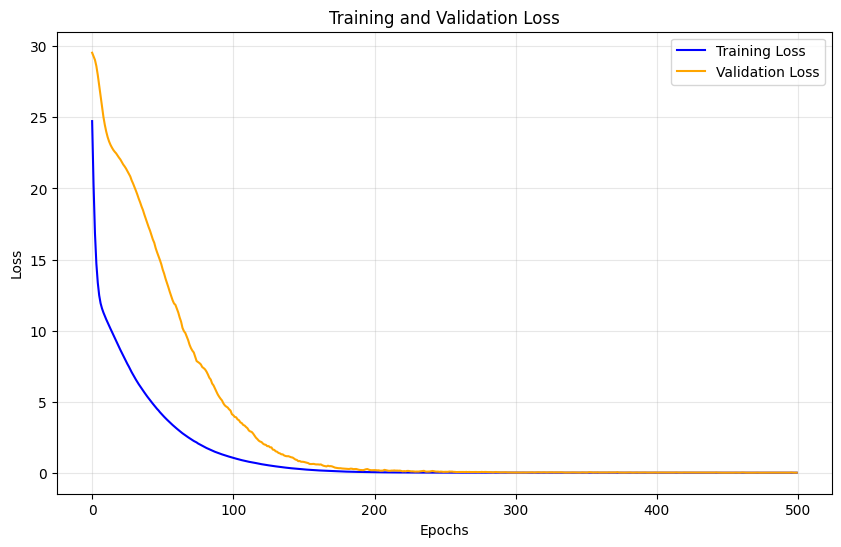

In [4]:
plot_loss(history)

# Prediction & Performance

In [20]:
# 2D Map 결과 도출을 위한 지도 파라미터 세팅
proj = '+proj=lcc +lat_1=30 +lat_2=60 +lon_1=126 +lat_0=38 +lon_0=126 +ellps=GRS80 +units=m'
atob = {
    0: 'G', 1: 'F', 2: 'K', 3: 'J', 4: 'E', 5: 'D',
    6: 'O', 7: 'C', 8: 'A', 9: 'Q', 10: 'P', 11: 'B',
    12: 'M', 13: 'L', 14: 'N', 15: 'I', 16: 'H'}
region_columns = {
    'A': 'Seoul City', 'B': 'Incheon City', 'C': 'Busan City', 'D': 'Daegu City',
    'E': 'Gwangju City', 'F': 'Gyeonggi-do', 'G': 'Gangwon-do', 'H': 'Chungbuk-do',
    'I': 'Chungnam-do', 'J': 'Gyeongbuk-do', 'K': 'Gyeongnam-do', 'L': 'Jeonbuk-do',
    'M': 'Jeonnam-do', 'N': 'Jeju-do', 'O': 'Daejeon City', 'P': 'Ulsan City', 'Q': 'Sejong City'}

def get_ctprvn_map() -> gpd.GeoDataFrame:
    path = '/home/user/workdir/main/resources/geom/ctp_rvn.shp'
    ctprvn = gpd.GeoDataFrame.from_file(path, encoding='cp949')
    ctprvn.crs = 'EPSG:5179'
    return ctprvn

def get_base_raster(ctprvn:gpd.GeoDataFrame) -> gpd.GeoDataFrame:
    points = [Point(i, j)
                for i in range(-180000, -180000 + 9000 * 67, 9000)
                for j in range(-585000, -585000 + 9000 * 82, 9000)]
    grid_data = gpd.GeoDataFrame(points, geometry='geometry', columns=['geometry'])
    grid_data.crs = ctprvn.to_crs(proj).crs
    grid_data.loc[:,'x_m'] = grid_data.geometry.x
    grid_data.loc[:,'y_m'] = grid_data.geometry.y
    grid_data.loc[:,'value'] = 0
    grid_data.loc[:,'index'] = grid_data.index
    return grid_data

def get_region_pixel_indices() -> list:
    ctprvn = get_ctprvn_map()
    grid_data = get_base_raster(ctprvn)

    cities = {
        0: '강원도', 1: '경기도', 2: '경상남도', 3: '경상북도',
        4: '광주광역시', 5: '대구광역시', 6: '대전광역시', 7: '부산광역시',
        8: '서울특별시', 9: '세종특별자치시', 10: '울산광역시', 11: '인천광역시',
        12: '전라남도', 13: '전라북도', 14: '제주특별자치도', 15: '충청남도',
        16: '충청북도'
    }

    gdf_joined_loc = ['CTPRVN_CD', 'CTP_ENG_NM', 'CTP_KOR_NM', 'index_right0']
    gdf_joined = gpd.sjoin(ctprvn, grid_data.to_crs(5179), predicate='contains')

    indices = gpd.GeoDataFrame(pd.merge(
        left=grid_data, right=gdf_joined.loc[:,gdf_joined_loc], 
        how='left', left_on='index', right_on='index_right0'
    ), geometry='geometry').dropna()
    pixel_indices = \
        [[(idx%82, idx//82) for idx in indices.loc[indices.CTP_KOR_NM==cities[region]].index.tolist()]
         for region, _ in cities.items()]
    return pixel_indices

ctprvn = get_ctprvn_map()
ctprvn_proj = ctprvn.to_crs(proj)

# 건국대(서울대)에서 제공한 대한민국 국토 grid 정보
grid_alloc = (
    pd.read_csv('/home/user/workdir/main/resources/geom/grid_allocation.csv') # load grid allocation data
    .sort_values(by=['Row', 'Column', 'Ratio'], ascending=[True, True, False]) # sort by row, column, ratio
    .drop_duplicates(subset=['Row', 'Column'], keep='first') # drop duplicates
    .reset_index(drop=True) # reset index
)

# 정부에서 배포하는 대한민국 국토 grid 정보
pixel_indices = get_region_pixel_indices()
total_index = []
for idx, grids in enumerate(pixel_indices):
    for grid in grids:
        total_index.append([
            grid[1], grid[0], 100.0, atob[idx], region_columns[atob[idx]]
        ])
total_index = pd.DataFrame(total_index, columns=grid_alloc.columns)

# 두 기관에서 주는 grid에 한두픽셀씩 비어있는 부분이 있어, 두 기관 데이터를 모두 참조하여 중복되는 픽셀을 정리 후 최종 국토 grid 정보를 취득
grid_alloc = pd.concat([
    grid_alloc.drop(columns=['Ratio', 'Region_Name']),
    total_index.drop(columns=['Ratio', 'Region_Name'])
]).sort_values(by=['Region_Code']).drop_duplicates().reset_index(drop=True)
grid_alloc[['Row', 'Column']] = grid_alloc[['Row', 'Column']] - 1

row_indices, col_indices = zip(*grid_alloc[['Row', 'Column']].values)
offset_x, offset_y = 4500, 4500 # 지도 위치 맞추기

# 마스킹 처리
mask = np.zeros((82, 67))
mask[row_indices, col_indices] = 1

cmap_white = mpl.colormaps['jet']
cmap_white.set_under('white')

In [21]:
test_split = 0.4  # 테스트 데이터 비율 (20%)
random_seed = 42  # 랜덤 시드
model = tf.keras.models.load_model('/home/user/workdir/main/src/model/nitrate/learning_rate/final_model')

pred_emis_data = []
pred_time_data = []
pred_boundary_data = []

# Load Test Data
emis_ctrl_2019_10 = pd.read_csv(
    '/home/user/workdir/main/resources/ctrl/precursor_control_2019.csv', index_col=0)
emis_ctrl_2019_10['Boundary'] = 1.0

ctrl_data = pd.concat([emis_ctrl_2019_10], axis=0)
ctrl_data = ctrl_data.reset_index(drop=True).values

base_path_2019 = "/home/user/workdir/main/datasets/concentration/2019/"

conc_path = []
for i in range(1, 120): 
    conc_path.append(os.path.join(base_path_2019, '1.00', f'ACONC.{i}'))

conc_data = []
for path in conc_path:
    with nc.Dataset(path) as f:
        conc_data.append(f.variables['Nitrate'][:].data.squeeze())  # ncf 파일 내 목적변수를 지정 
conc_data = np.array(conc_data).reshape(len(conc_path), 82, 67, 1)
    
pred_emis_data, pred_boundary_data = ctrl_data[:, :85], ctrl_data[:, 85]

_, X_emis_test, _, X_boundary_test, _, y_test = train_test_split(pred_emis_data, pred_boundary_data, conc_data, test_size=test_split, random_state=random_seed)

y_preds = model.predict([X_emis_test,  X_boundary_test]) # 2가지 경계 조건에 따른 1년치 PM2.5 데이터 예측
y_pred = y_preds.squeeze()
y_true = y_test.squeeze()

2/2 [==============================] - 1s 11ms/step


In [22]:
mask_expanded = np.repeat(mask[np.newaxis, :, :], repeats=y_true.shape[0], axis=0) # (24, 82, 67)

pred_conc_map_w_lines = np.where(mask_expanded == 1, y_pred, 0)  # 마스킹 적용
true_conc_map_w_lines = np.where(mask_expanded == 1, y_true, 0) # 마스킹 적용
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


In [23]:
def plot_scatter(ax, y_true, y_pred):
    r_x, r_y = np.polyfit(y_true, y_pred, 1)
    ax.hist2d(
        y_true, y_pred,
        bins=150, cmap='jet', cmin=1,
        norm=mpl.colors.LogNorm(vmin=1, vmax=1000),
    )
    ax.plot(
        y_true, r_x*y_true + r_y,
        color='red', label=f"y={r_x:.4f}x+{r_y:.4f}")
    r2 = r2_score(y_true, y_pred)
    ax.text(
        0.05, 0.95, f"$R^2={r2:.4f}$ \nSlope={r_x:.4f}\nIntercept={r_y:.4f}",
        verticalalignment='top', horizontalalignment='left',
        transform=ax.transAxes, fontsize=11
    )
    ax.grid(alpha=0.25)
    return ax

def get_score(y_true, y_pred):
    batch_size = y_true.shape[0]
    y_true = y_true.reshape(batch_size, -1)
    y_pred = y_pred.reshape(batch_size, -1)
    y_norm_err = np.abs(y_true - y_pred) / np.mean(y_true, axis=1, keepdims=True)
    y_err_mean = np.mean(y_norm_err, axis=1)
    y_err_std = np.percentile(y_norm_err, q=5, axis=1)
    return y_err_mean, y_err_std

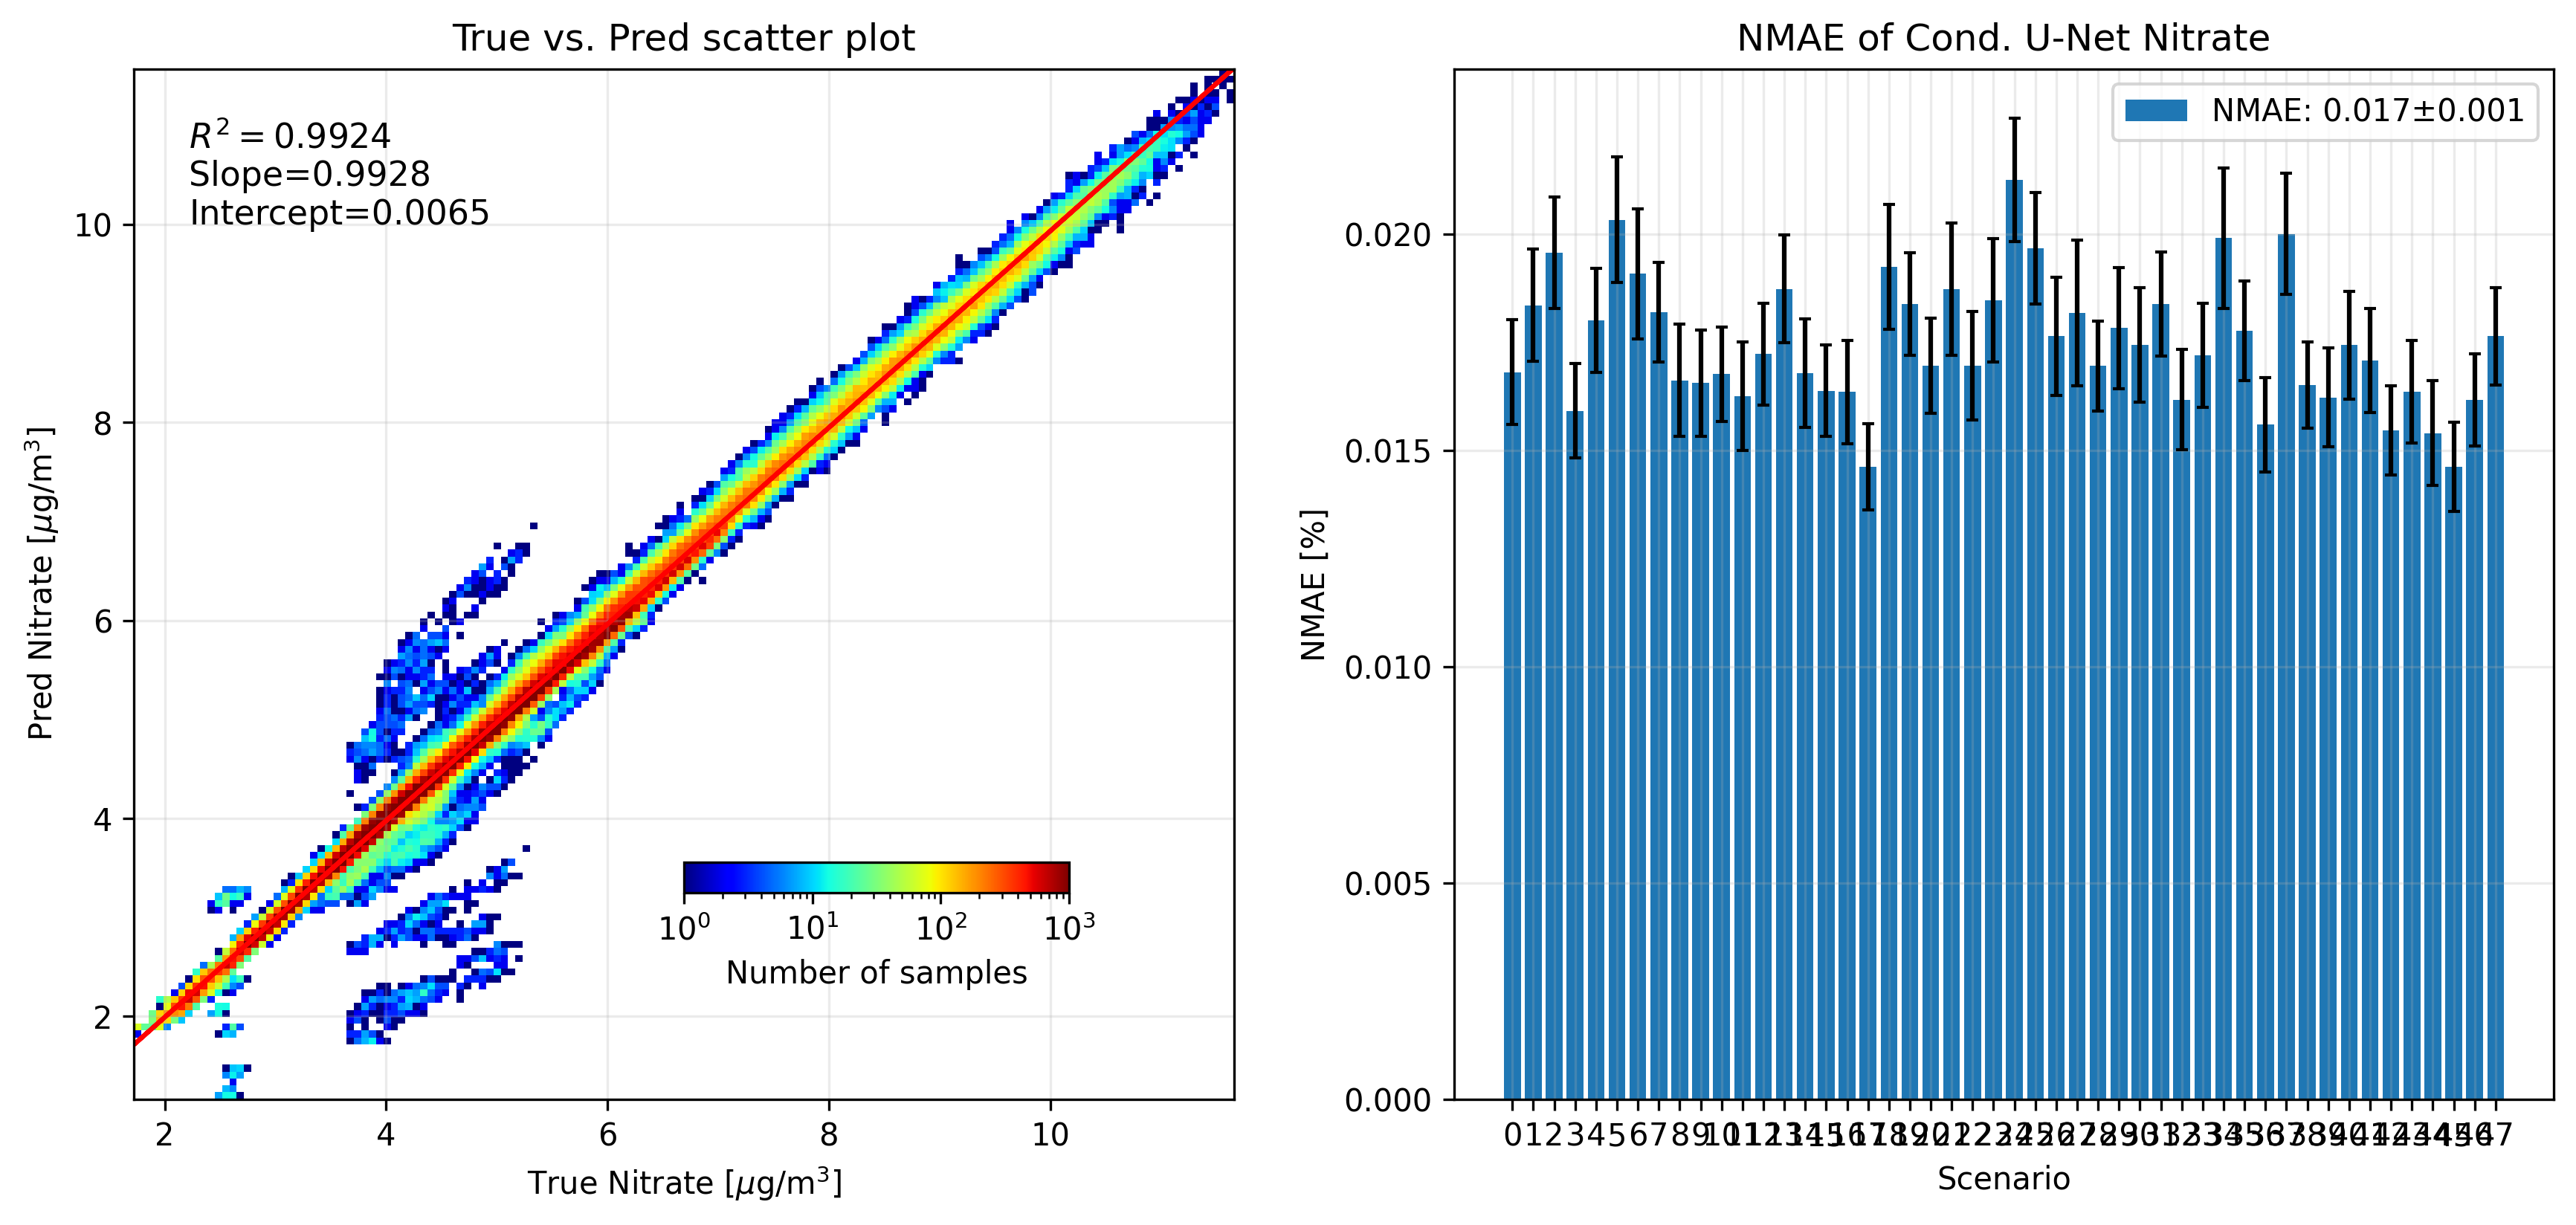

In [24]:
y_pred_ori = y_pred.reshape(-1)
y_true_ori = y_true.reshape(-1)
fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
axes[0] = plot_scatter(axes[0], y_true_ori, y_pred_ori)
axes[0].grid(alpha=0.25)
axes[0].set_title("True vs. Pred scatter plot")
axes[0].set_xlabel('True Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes[0].set_ylabel('Pred Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes[0].inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

y_true_ori = y_test.reshape(y_test.shape[0], -1)
y_pred_ori = y_preds.reshape(y_test.shape[0], -1)
score, score_std = get_score(y_true, y_pred)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes[1].bar(np.arange(y_test.shape[0]), score, yerr=score_std, label=label_text, capsize=2)
# axes[1].set_ylim(0, 0.052)
axes[1].set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
# axes[1].legend(bbox_to_anchor=(0.3, 1.1), loc='upper center', frameon=False)
axes[1].grid(alpha=0.25)
axes[1].legend()
axes[1].set_title("NMAE of Cond. U-Net Nitrate")
axes[1].set_xlabel('Scenario')
axes[1].set_ylabel('NMAE [%]')
plt.show()

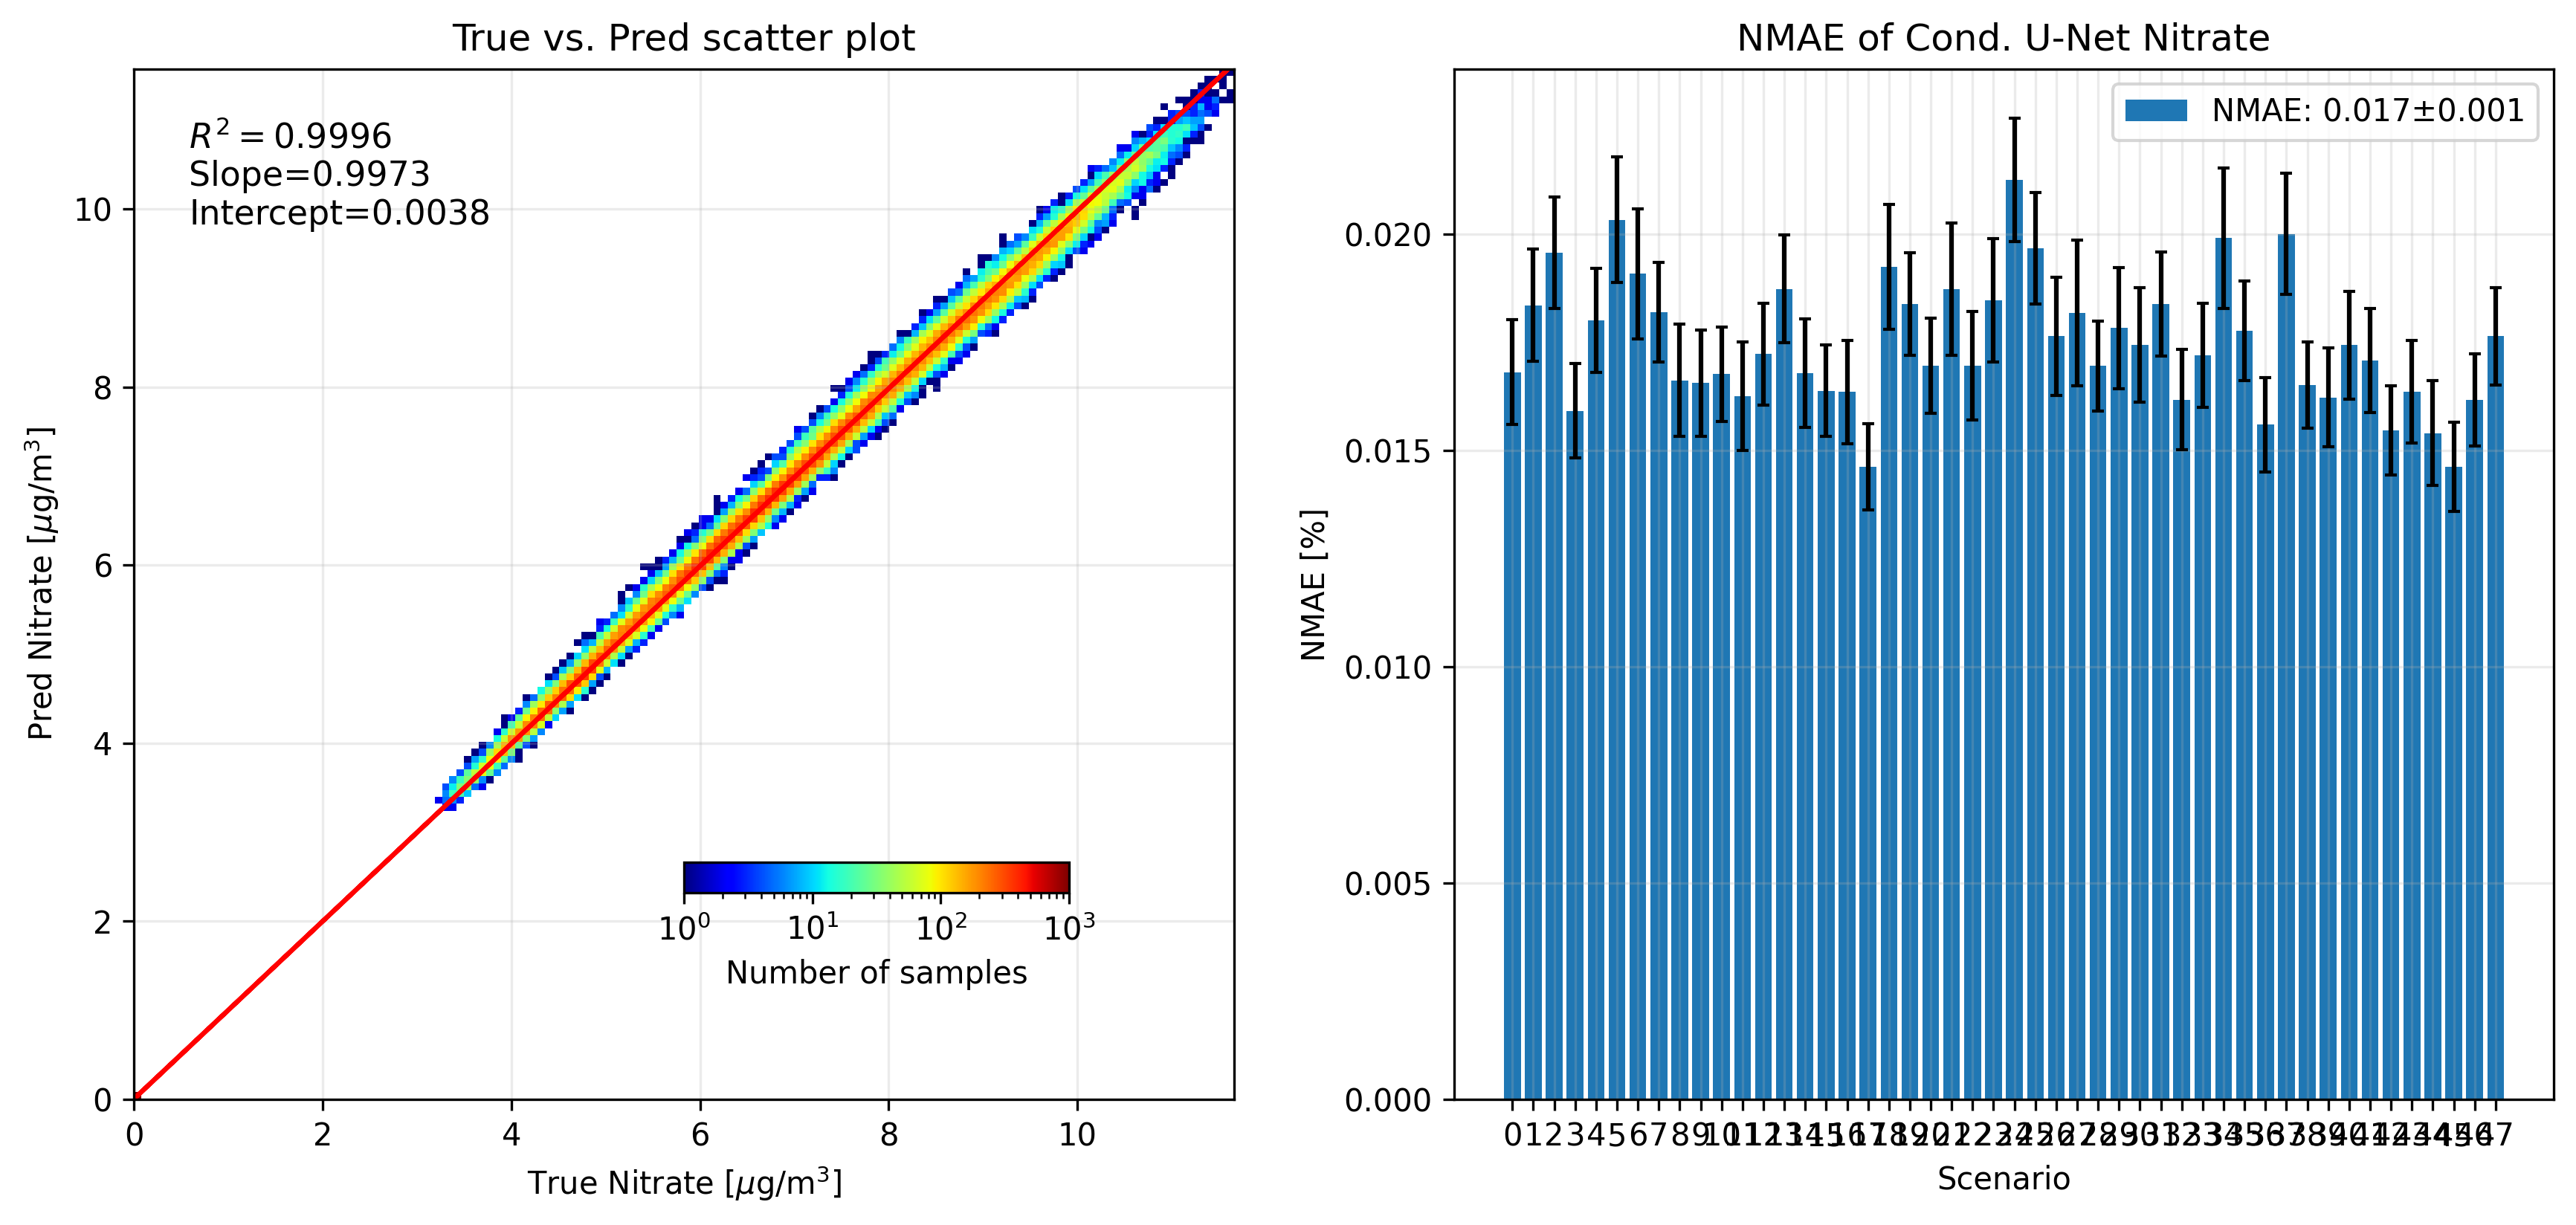

In [25]:
y_true_modi = true_conc_map_w_lines.reshape(-1)
y_pred_modi = pred_conc_map_w_lines.reshape(-1)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
axes[0] = plot_scatter(axes[0], y_true_modi, y_pred_modi)
axes[0].grid(alpha=0.25)
# axes[0].set_xlim(3, 67)  # True 축 범위를 조정
# axes[0].set_ylim(3, 69)  # Pred 축 범위를 조정
axes[0].set_title("True vs. Pred scatter plot")
axes[0].set_xlabel('True Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes[0].set_ylabel('Pred Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes[0].inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

y_true_modi = y_test.reshape(y_test.shape[0], -1)
y_pred_modi = y_preds.reshape(y_test.shape[0], -1)
score, score_std = get_score(y_true_modi, y_pred_modi)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes[1].bar(np.arange(y_test.shape[0]), score, yerr=score_std, label=label_text, capsize=2)
# axes[1].set_ylim(0, 0.052)
axes[1].set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
# axes[1].legend(bbox_to_anchor=(0.3, 1.1), loc='upper center', frameon=False)
axes[1].grid(alpha=0.25)
axes[1].legend()
axes[1].set_title("NMAE of Cond. U-Net Nitrate")
axes[1].set_xlabel('Scenario')
axes[1].set_ylabel('NMAE [%]')

plt.show()

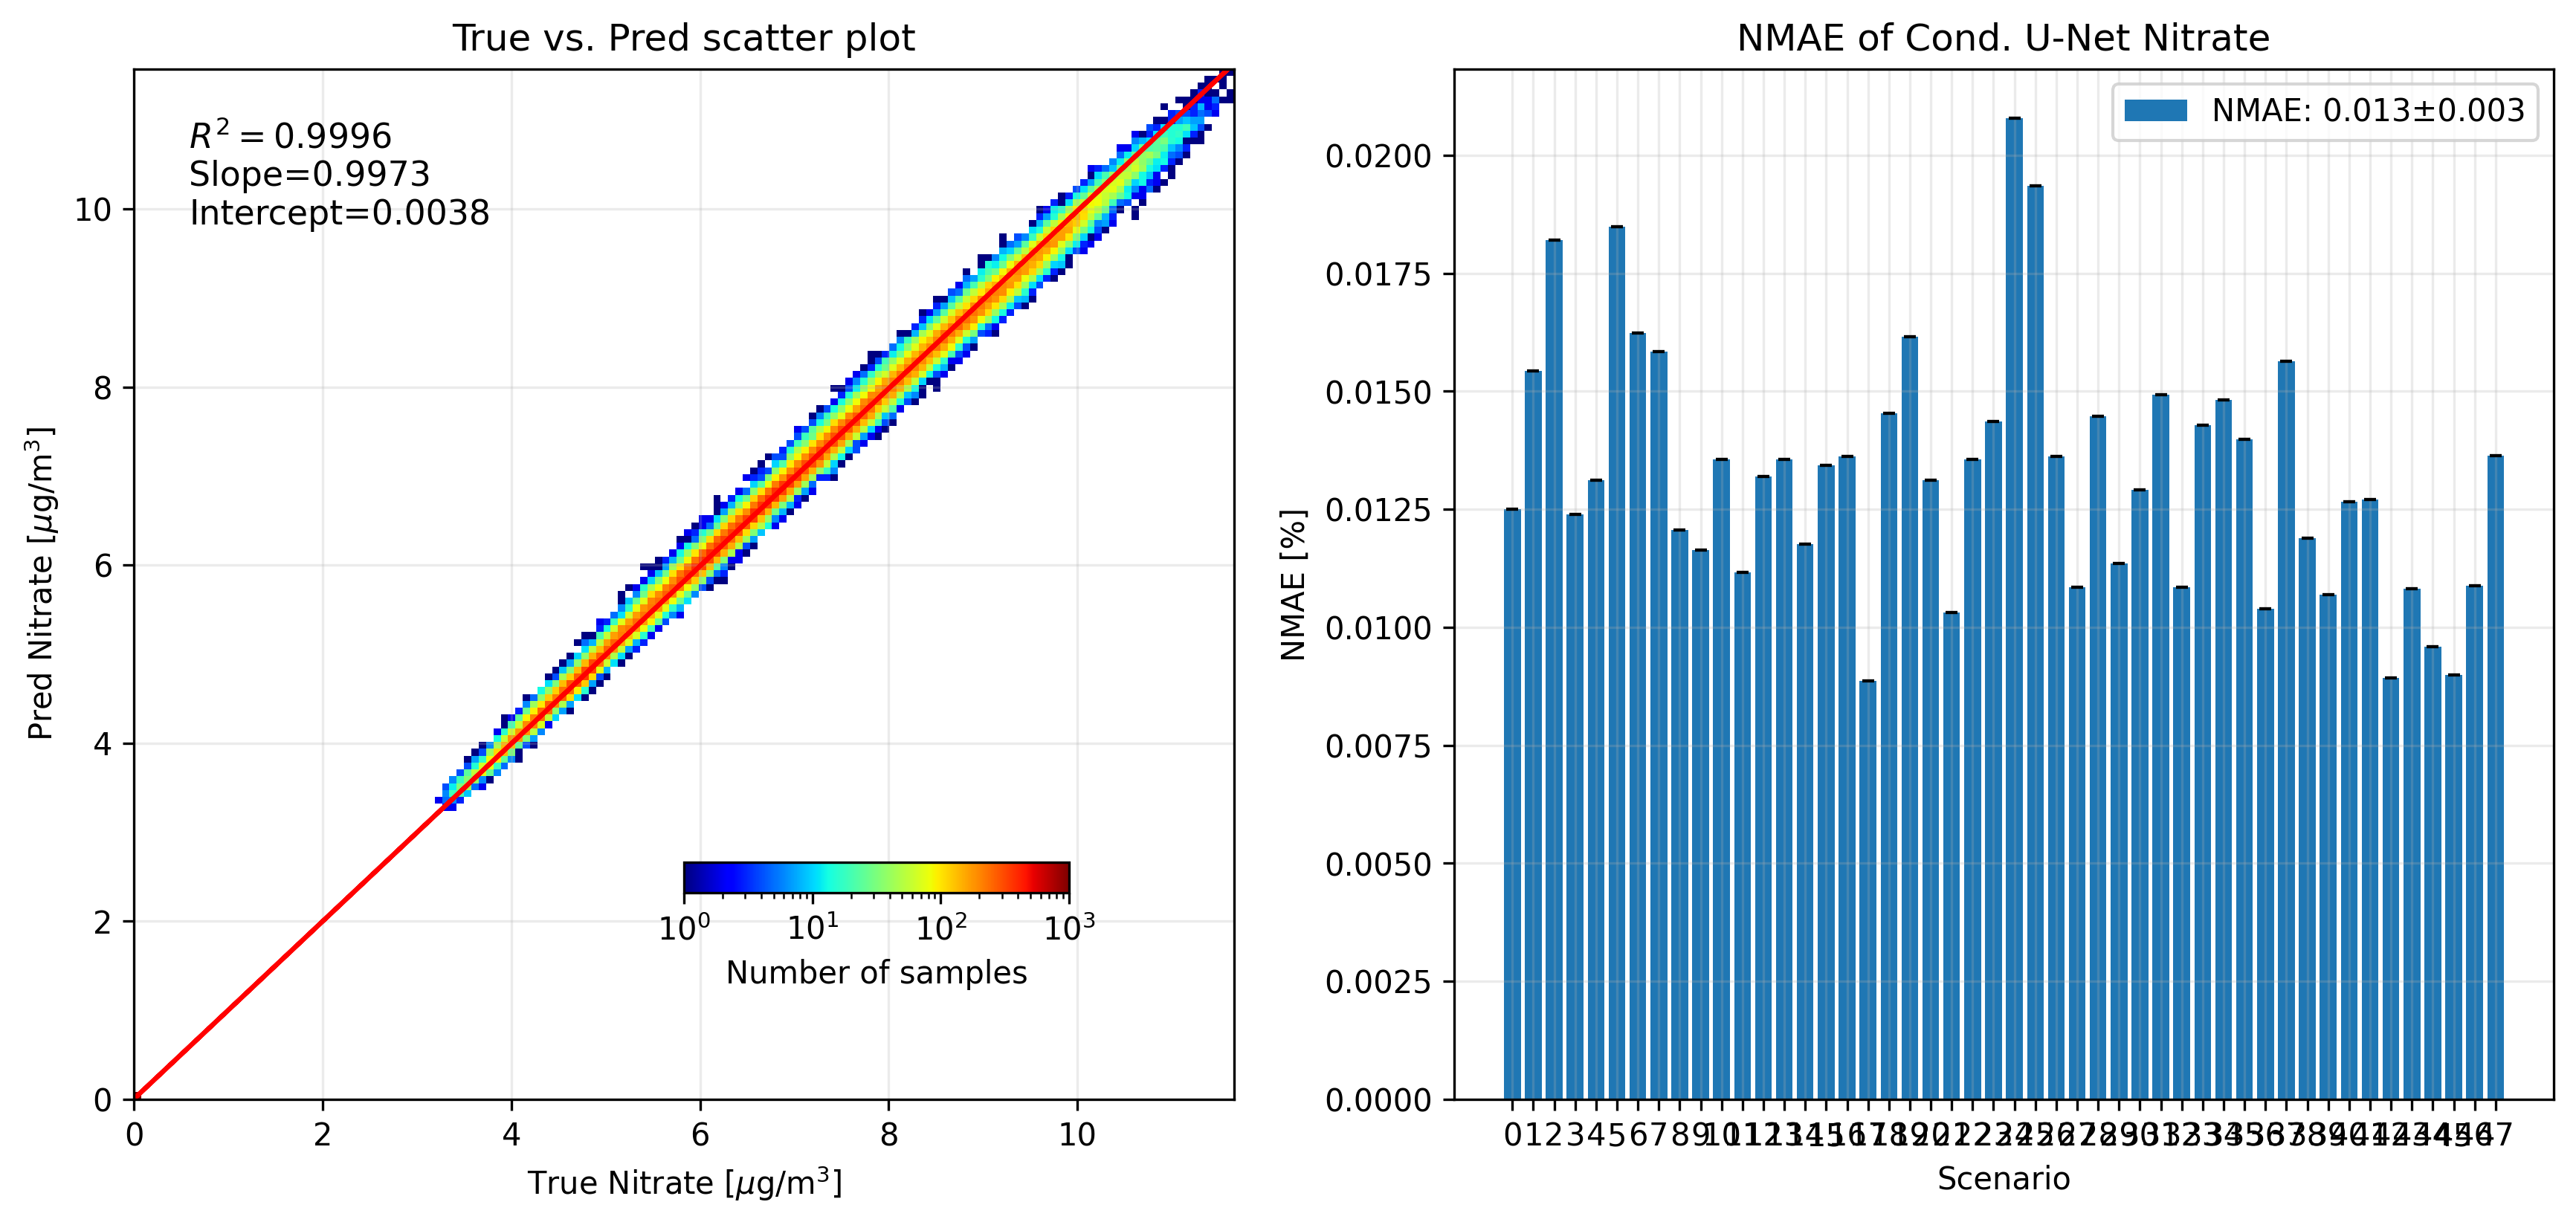

In [26]:
y_true_modi = true_conc_map_w_lines.reshape(-1)
y_pred_modi = pred_conc_map_w_lines.reshape(-1)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), dpi=300)
axes[0] = plot_scatter(axes[0], y_true_modi, y_pred_modi)
axes[0].grid(alpha=0.25)
axes[0].set_title("True vs. Pred scatter plot")
axes[0].set_xlabel('True Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
axes[0].set_ylabel('Pred Nitrate [$\mu \mathrm{g}/\mathrm{m}^3$]')
cbaxes = axes[0].inset_axes([0.5, 0.2, 0.35, 0.03])
cb = plt.colorbar(
    mpl.cm.ScalarMappable(norm=mpl.colors.LogNorm(vmin=1, vmax=1000), cmap='jet'),
    cax=cbaxes, label='Number of samples', orientation='horizontal')
cb.set_label(label='Number of samples', fontsize=10)

score, score_std = get_score(true_conc_map_w_lines, pred_conc_map_w_lines)
label_text = f'NMAE: {np.mean(score):.3f}±{np.std(score):.3f}'

axes[1].bar(np.arange(y_test.shape[0]), score, yerr=score_std, label=label_text, capsize=2)
axes[1].set_xticks(np.arange(y_test.shape[0]), range(y_test.shape[0]))
axes[1].grid(alpha=0.25)
axes[1].legend()
axes[1].set_title("NMAE of Cond. U-Net Nitrate")
axes[1].set_xlabel('Scenario')
axes[1].set_ylabel('NMAE [%]')

plt.show()

In [27]:
print(y_pred.shape)
print(y_true.shape)
print(pred_conc_map_w_lines.shape)
print(true_conc_map_w_lines.shape)

(48, 82, 67)
(48, 82, 67)
(48, 82, 67)
(48, 82, 67)


[41]


/tmp/ipykernel_1462562/3432564490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1462562/3432564490.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1462562/3432564490.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1462562/3432564490.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1462562/3432564490.py:62: UserWarning: set_ti

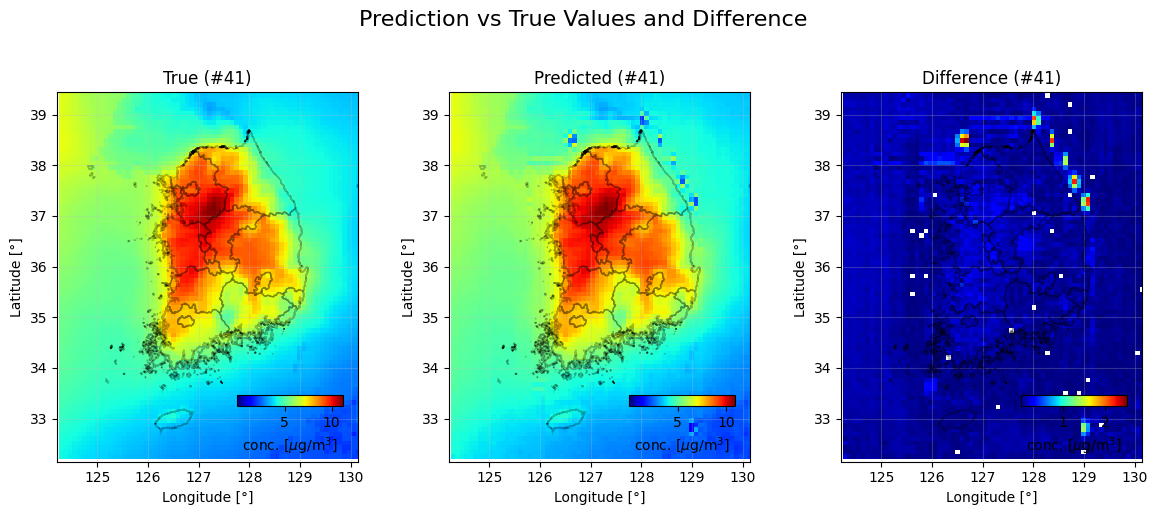

[11]


/tmp/ipykernel_1462562/3432564490.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1462562/3432564490.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1462562/3432564490.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
/tmp/ipykernel_1462562/3432564490.py:43: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
/tmp/ipykernel_1462562/3432564490.py:62: UserWarning: set_ti

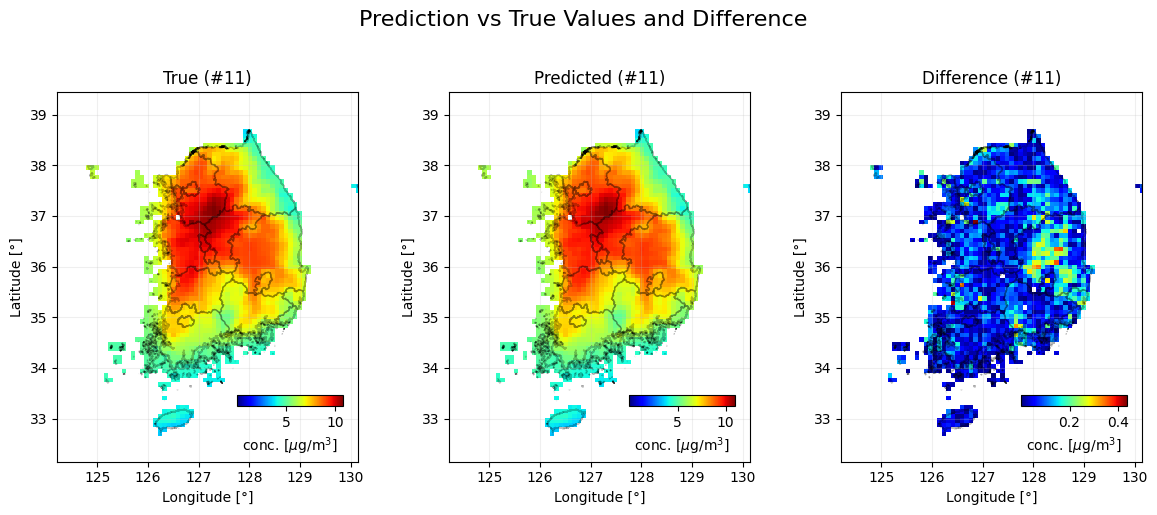

In [28]:
def plot_prediction_loss(y_true, y_pred, num_samples=1):
    indices = np.random.choice(len(y_true), num_samples, replace=False)
    print(indices)  # 선택된 인덱스 확인
    fig, axes = plt.subplots(num_samples, 3, figsize=(15, 5 * num_samples))
    if num_samples == 1:
        axes = np.expand_dims(axes, axis=0)  # 2차원으로 변환

    fig.suptitle("Prediction vs True Values and Difference", fontsize=16, y=1.02)
    for i, idx in enumerate(indices):
        # True 이미지
        axes[i, 0].imshow(
            y_true[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 0] = ctprvn_proj.boundary.plot(ax=axes[i, 0], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 0].set_xlim(-180000, 414000)
        axes[i, 0].set_ylim(-585000, 144000)
        axes[i, 0].set_xlabel('Longitude [°]')
        axes[i, 0].set_ylabel('Latitude [°]')
        axes[i, 0].set_title(f"True (#{idx})")
        axes[i, 0].grid(alpha=0.25, color='silver')
        axes[i, 0].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 0].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 0].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 0].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')

        # Predicted 이미지
        axes[i, 1].imshow(
            y_pred[idx][::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 1] = ctprvn_proj.boundary.plot(ax=axes[i, 1], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 1].set_xlim(-180000, 414000)
        axes[i, 1].set_ylim(-585000, 144000)
        axes[i, 1].set_xlabel('Longitude [°]')
        axes[i, 1].set_ylabel('Latitude [°]')
        axes[i, 1].set_title(f"Predicted (#{idx})")
        axes[i, 1].grid(alpha=0.25, color='silver')
        axes[i, 1].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 1].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 1].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 1].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
        # Difference 이미지
        difference = np.abs(y_true[idx] - y_pred[idx])  # 차이 절대값
        axes[i, 2].imshow(
            difference[::-1], 
            cmap=cmap_white,
            extent=(-180000+offset_x, 414000+offset_x, -585000+offset_y, 144000+offset_y),
            vmin=0.001)
        axes[i, 2] = ctprvn_proj.boundary.plot(ax=axes[i, 2], edgecolor='black', facecolor='none', linewidth=1, alpha=0.25)
        axes[i, 2].set_xlim(-180000, 414000)
        axes[i, 2].set_ylim(-585000, 144000)
        axes[i, 2].set_xlabel('Longitude [°]')
        axes[i, 2].set_ylabel('Latitude [°]')
        axes[i, 2].set_title(f"Difference (#{idx})")
        axes[i, 2].grid(alpha=0.25, color='silver')
        axes[i, 2].set_xticklabels([f"{i}" for i in range(124, 132, 1)])
        axes[i, 2].set_yticklabels([f"{i}" for i in range(32, 40, 1)])
        cbaxes = axes[i, 2].inset_axes([0.6, 0.15, 0.35, 0.03])
        cb = plt.colorbar(axes[i, 2].images[0], cax=cbaxes, orientation='horizontal', label='Nitrate ($\mu g/m^3$)')
        cb.set_label(label='conc. [$\mu \mathrm{g}/\mathrm{m}^3$]')
        
    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.subplots_adjust(wspace=-0.4, hspace=0.2)
    plt.show()

plot_prediction_loss(y_true, y_pred)
plot_prediction_loss(true_conc_map_w_lines, pred_conc_map_w_lines)

In [29]:
tf.keras.backend.clear_session()